In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import MultiTaskLasso, Lasso
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

In [100]:
df = pd.read_csv('yellow_tripdata_2017-06.csv')

# subtract tolls amount from total amount
df['total_amount'] = df['total_amount'] - df['tolls_amount']

# drop the tolls_amount column
df = df.drop(['tolls_amount'], axis=1)

# drop refund records
df = df[df['total_amount'] >= 0]

# compute trip minutes and create the time_difference column using trip minutes 
t1 = pd.to_datetime(df['tpep_pickup_datetime']) 
t2 = pd.to_datetime(df['tpep_dropoff_datetime'])
df['time_difference'] = (t2 - t1)/np.timedelta64(1,'m')

# drop outliers
idx1 = df[(df['time_difference'] == 0) & (df['trip_distance'] != 0)].index
df = df.drop(idx1)

# drop outliers
idx2 = df[(df['trip_distance'] == 0) & (df['fare_amount'] != 0)].index
df = df.drop(idx2)

# no pick-up locations information provided
idx3 = df[(df['PULocationID'] == 264) | (df['PULocationID'] == 265)].index
df = df.drop(idx3)

# drop tpep_pickup_datetime and tpep_dropoff_datetime columns
df['pu_dates'] = pd.to_datetime(df['tpep_pickup_datetime']) #.dt.normalize()
df['do_dates'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# create new column that shows when a taxi trip was occured
df['day_of_week'] = df['pu_dates'].dt.day_name()

# drop outliers
df = df[df['time_difference'] < 180]
df = df[df['time_difference'] > 0.5]
df = df[df['trip_distance'] < 200]

# drop outliers since their total fairs are too much compared to trip distance 
df = df.drop([5773420, 2427507])

In [101]:
df.head(3)

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,improvement_surcharge,total_amount,time_difference,pu_dates,do_dates,day_of_week
0,2,6,1.03,1,N,161,140,1,7.5,1.0,0.5,1.86,0.3,11.16,9.016667,2017-06-08 07:52:31,2017-06-08 08:01:32,Thursday
1,2,6,1.03,1,N,162,233,1,6.0,1.0,0.5,2.34,0.3,10.14,5.700000,2017-06-08 08:08:18,2017-06-08 08:14:00,Thursday
3,2,6,1.43,1,N,142,48,1,8.5,1.0,0.5,0.88,0.3,11.18,10.866667,2017-06-29 15:52:35,2017-06-29 16:03:27,Thursday


In [102]:
# import taxi data dictionary

df1 = pd.read_csv('taxi+_zone_lookup.csv')

In [103]:
# divide data by each day
# create 'hour' variable indicating what time a taxi trip took place

df_m = df[df['day_of_week'] == 'Monday']
df_m['hour'] = df_m['pu_dates'].dt.hour

df_t = df[df['day_of_week'] == 'Tuesday']
df_t['hour'] = df_t['pu_dates'].dt.hour

df_w = df[df['day_of_week'] == 'Wednesday']
df_w['hour'] = df_w['pu_dates'].dt.hour

df_th = df[df['day_of_week'] == 'Thursday']
df_th['hour'] = df_th['pu_dates'].dt.hour

df_f = df[df['day_of_week'] == 'Friday']
df_f['hour'] = df_f['pu_dates'].dt.hour

df_sa = df[df['day_of_week'] == 'Saturday']
df_sa['hour'] = df_sa['pu_dates'].dt.hour

df_s = df[df['day_of_week'] == 'Sunday']
df_s['hour'] = df_s['pu_dates'].dt.hour

C:\Python3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Python3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is add

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Python3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


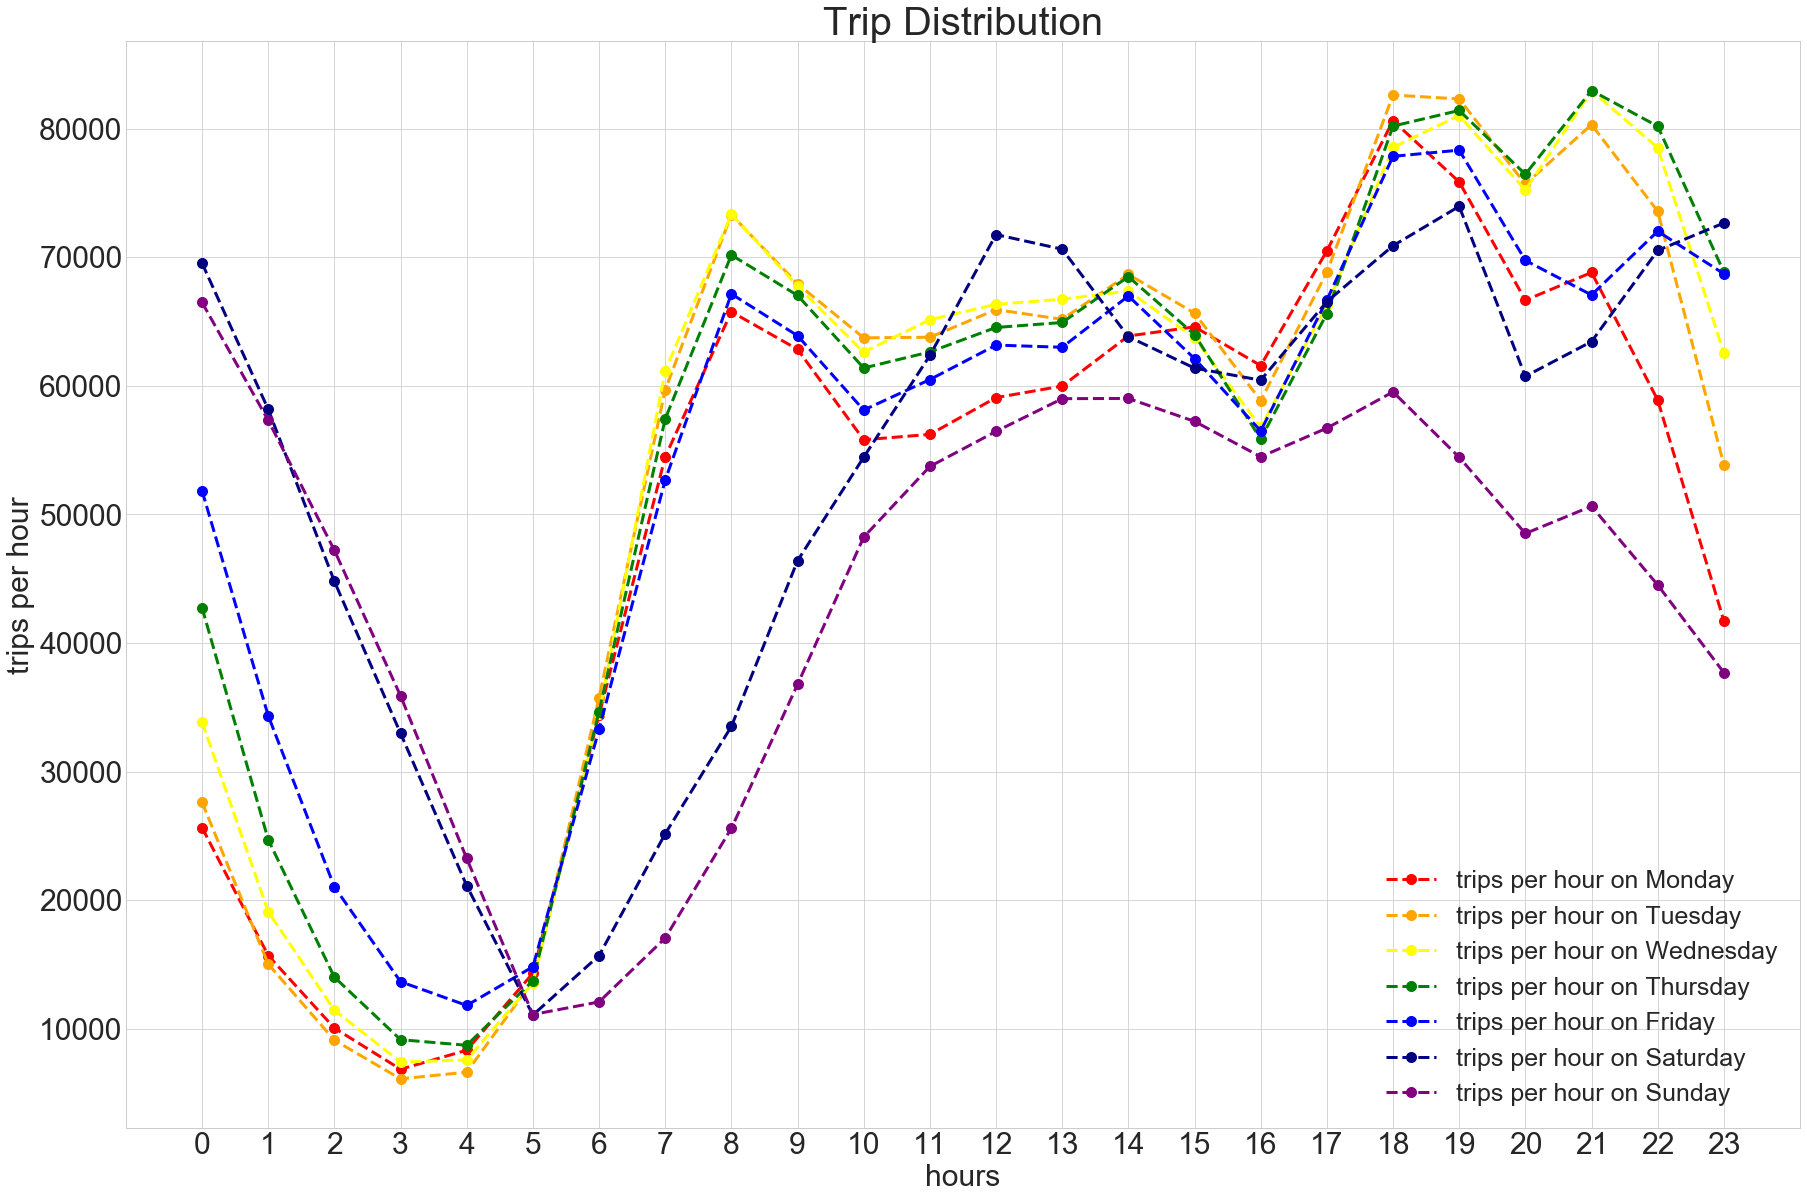

In [104]:
df_th['date'] = df_th['pu_dates'].dt.date
df_f['date'] = df_f['pu_dates'].dt.date
df_th0 = df_th[df_th['date'] != datetime.date(2017, 6, 1)]
df_f0 = df_f[df_f['date'] != datetime.date(2017, 6, 2)]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

plt.plot(df_m.groupby(['hour']).size(), label='trips per hour on Monday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'red')
plt.plot(df_t.groupby(['hour']).size(), label='trips per hour on Tuesday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'orange')
plt.plot(df_w.groupby(['hour']).size(), label='trips per hour on Wednesday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'yellow')
plt.plot(df_th0.groupby(['hour']).size(), label='trips per hour on Thursday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'green')
plt.plot(df_f0.groupby(['hour']).size(), label='trips per hour on Friday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'blue')
plt.plot(df_sa.groupby(['hour']).size(), label='trips per hour on Saturday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'navy')
plt.plot(df_s.groupby(['hour']).size(), label='trips per hour on Sunday', 
         linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = 'purple')
plt.legend(loc='lower right', prop={'size': 25}) 



plt.xlabel("hours", size = 30)
plt.ylabel("trips per hour", size = 30)
plt.title("Trip Distribution", size = 40)
plt.xticks(range(0, 24), size = 30)
plt.yticks(size = 30)
plt.show()

# Monday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


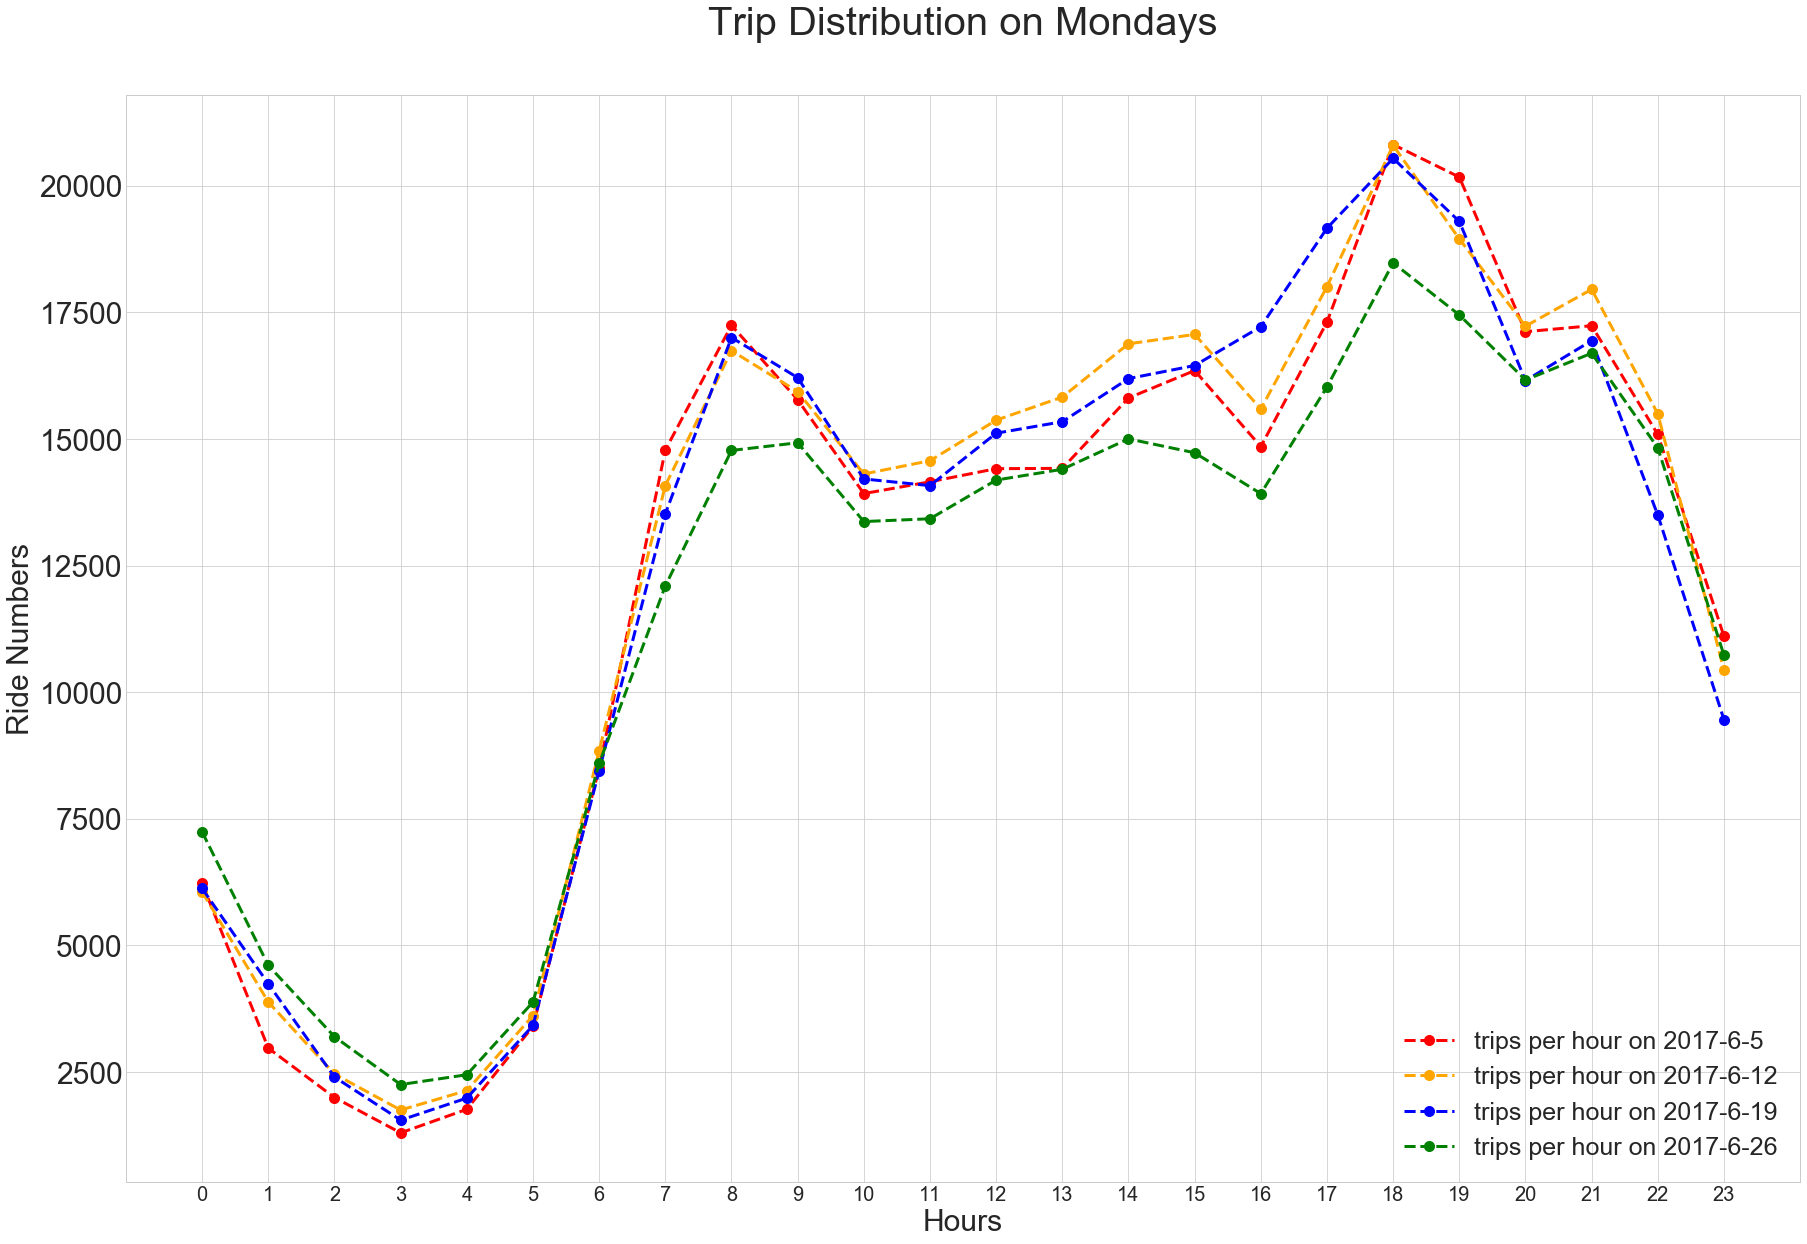

In [105]:
df_m['date'] = df_m['pu_dates'].dt.date
df_m1 = df_m[df_m['date'] == datetime.date(2017, 6, 5)]
df_m2 = df_m[df_m['date'] == datetime.date(2017, 6, 12)]
df_m3 = df_m[df_m['date'] == datetime.date(2017, 6, 19)]
df_m4 = df_m[df_m['date'] == datetime.date(2017, 6, 26)]

colors = ['red', 'orange', 'blue', 'green']
dates = ['2017-6-5', '2017-6-12', '2017-6-19', '2017-6-26']
dfs = [df_m1, df_m2, df_m3, df_m4]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(4):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Mondays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [106]:
df_m_hour89 = pd.DataFrame(df_m[(df_m['hour'] == 8) | (df_m['hour'] == 9)].groupby(['PULocationID']).size())
df_m_hour1819 = pd.DataFrame(df_m[(df_m['hour'] == 18) | (df_m['hour'] == 19)].groupby(['PULocationID']).size())
df_m_hour34 = pd.DataFrame(df_m[(df_m['hour'] == 3) | (df_m['hour'] == 4)].groupby(['PULocationID']).size())
df_m_hour2223 = pd.DataFrame(df_m[(df_m['hour'] == 22) | (df_m['hour'] == 23)].groupby(['PULocationID']).size())

df_m_hour34.columns = ['Count']
df_m_hour89.columns = ['Count']
df_m_hour1819.columns = ['Count']
df_m_hour2223.columns = ['Count']

lst1 = []
lst2 = []
for i in df_m_hour89.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_m_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_m_hour34.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])

lst7 = []
lst8 = []
for i in df_m_hour2223.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
#df_m1[df_m1['hour'] == 0].groupby(['PULocationID']).size()
df_m_hour89['Borough'] = lst1
df_m_hour89['Zone'] = lst2

df_m_hour1819['Borough'] = lst3
df_m_hour1819['Zone'] = lst4

df_m_hour34['Borough'] = lst5
df_m_hour34['Zone'] = lst6

df_m_hour2223['Borough'] = lst7
df_m_hour2223['Zone'] = lst8

In [239]:
idx89 = df_m_hour89.sort_values(by='Count', ascending=False)
#idx89.to_csv('mondays89.csv')
idx89.head()

,Count,Borough,Zone
PULocationID,,,
236,6543,Manhattan,Upper East Side North
237,6426,Manhattan,Upper East Side South
186,6040,Manhattan,Penn Station/Madison Sq West
170,5334,Manhattan,Murray Hill
138,5160,Queens,LaGuardia Airport


In [240]:
dfm89 = df_m[(df_m['hour'] == 8) | (df_m['hour'] == 9)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []
for i in idx89.index:
        
    avgf = dfm89[dfm89['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
        
    avgd = dfm89[dfm89['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
        
    avgt = dfm89[dfm89['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)
        
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
mondays89 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idx89.Zone)

#mondays89.to_csv('mondays_report89.csv')
mondays89.head(5)

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side North,12.852083,2.078197,12.231889,6.18,1.05,0.17
Upper East Side South,10.806075,1.580363,9.987504,6.84,1.08,0.16
Penn Station/Madison Sq West,13.347306,1.810040,14.409663,7.37,0.93,0.13
Murray Hill,12.755819,1.908382,12.262217,6.68,1.04,0.16
LaGuardia Airport,44.998874,10.546407,45.592041,4.27,0.99,0.23


In [243]:
print(mondays89['Average Fare per mile'].head(55).mean())
print(mondays89['Average Fare per minute'].head(55).mean())
print(mondays89['Average Distance per minute'].head(55).mean())

5.981818181818181
1.0367272727272727
0.17745454545454545


In [241]:
idx1819 = df_m_hour1819.sort_values(by='Count', ascending=False)
#idx1819.to_csv('mondays1819.csv')
idx1819.head()

,Count,Borough,Zone
PULocationID,,,
161,8158,Manhattan,Midtown Center
162,7456,Manhattan,Midtown East
237,7447,Manhattan,Upper East Side South
234,6384,Manhattan,Union Sq
230,6136,Manhattan,Times Sq/Theatre District


In [242]:
dfm1819 = df_m1[(df_m1['hour'] == 18) | (df_m1['hour'] == 19)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idx1819.index:
    
    avgf = dfm1819[dfm1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfm1819[dfm1819['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dfm1819[dfm1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
mondays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idx1819.Zone)

#mondays1819.to_csv('mondays_report1819.csv')
mondays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Midtown Center,14.260358,2.075062,13.173930,6.87,1.08,0.16
Midtown East,14.435045,2.184494,12.841295,6.61,1.12,0.17
Upper East Side South,12.304428,1.763146,10.527199,6.98,1.17,0.17
Union Sq,13.861943,2.042663,12.254035,6.79,1.13,0.17
Times Sq/Theatre District,14.733736,2.227510,13.731386,6.61,1.07,0.16


In [244]:
print(mondays1819['Average Fare per mile'].head(55).mean())
print(mondays1819['Average Fare per minute'].head(55).mean())
print(mondays1819['Average Distance per minute'].head(55).mean())

6.198181818181819
1.1950909090909092
0.1976363636363636


In [245]:
idx34 = df_m_hour34.sort_values(by='Count', ascending=False)
#idx34.to_csv('mondays34.csv')
idx34.head()

,Count,Borough,Zone
PULocationID,,,
48,1116,Manhattan,Clinton East
79,921,Manhattan,East Village
230,768,Manhattan,Times Sq/Theatre District
68,704,Manhattan,East Chelsea
249,615,Manhattan,West Village


In [246]:
dfm34 = df_m1[(df_m1['hour'] == 3) | (df_m1['hour'] == 4)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idx34.index:
    
    avgf = dfm34[dfm34['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfm34[dfm34['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dfm34[dfm34['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
mondays34 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idx34.Zone)

#mondays34.to_csv('mondays_report34.csv')
mondays34.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Clinton East,17.069812,4.050047,11.647574,4.21,1.47,0.35
East Village,15.547081,3.635784,11.099820,4.28,1.40,0.33
Times Sq/Theatre District,19.134333,4.822111,13.604815,3.97,1.41,0.35
East Chelsea,16.704028,3.873403,12.123380,4.31,1.38,0.32
West Village,17.503967,4.247025,12.790083,4.12,1.37,0.33


In [247]:
print(mondays34['Average Fare per mile'].head(55).mean())
print(mondays34['Average Fare per minute'].head(55).mean())
print(mondays34['Average Distance per minute'].head(55).mean())

4.13090909090909
1.538181818181818
0.37672727272727274


In [248]:
idx2223 = df_m_hour2223.sort_values(by='Count', ascending=False)
#idx2223.to_csv('mondays2223.csv')
idx2223.head()

,Count,Borough,Zone
PULocationID,,,
230,5529,Manhattan,Times Sq/Theatre District
161,5279,Manhattan,Midtown Center
138,5161,Queens,LaGuardia Airport
132,4267,Queens,JFK Airport
162,3899,Manhattan,Midtown East


In [252]:
dfm2223 = df_m1[(df_m1['hour'] == 22) | (df_m1['hour'] == 23)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idx2223.index:
    
    avgf = dfm2223[dfm2223['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfm2223[dfm2223['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dfm2223[dfm2223['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
mondays2223 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idx2223.Zone)

#mondays2223.to_csv('mondays_report2223.csv')
mondays2223.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Times Sq/Theatre District,13.468965,2.444390,11.023269,5.51,1.22,0.22
Midtown Center,14.080836,2.554377,11.413307,5.51,1.23,0.22
LaGuardia Airport,36.534838,9.683427,22.760425,3.77,1.61,0.43
JFK Airport,53.362955,16.080145,29.214486,3.32,1.83,0.55
Midtown East,14.151937,2.597619,10.929600,5.45,1.29,0.24


In [250]:
print(mondays2223['Average Fare per mile'].head(55).mean())
print(mondays2223['Average Fare per minute'].head(55).mean())
print(mondays2223['Average Distance per minute'].head(55).mean())

5.149999999999999
1.278181818181818
0.2525454545454545


# Tuesday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<Figure size 2160x1440 with 0 Axes>

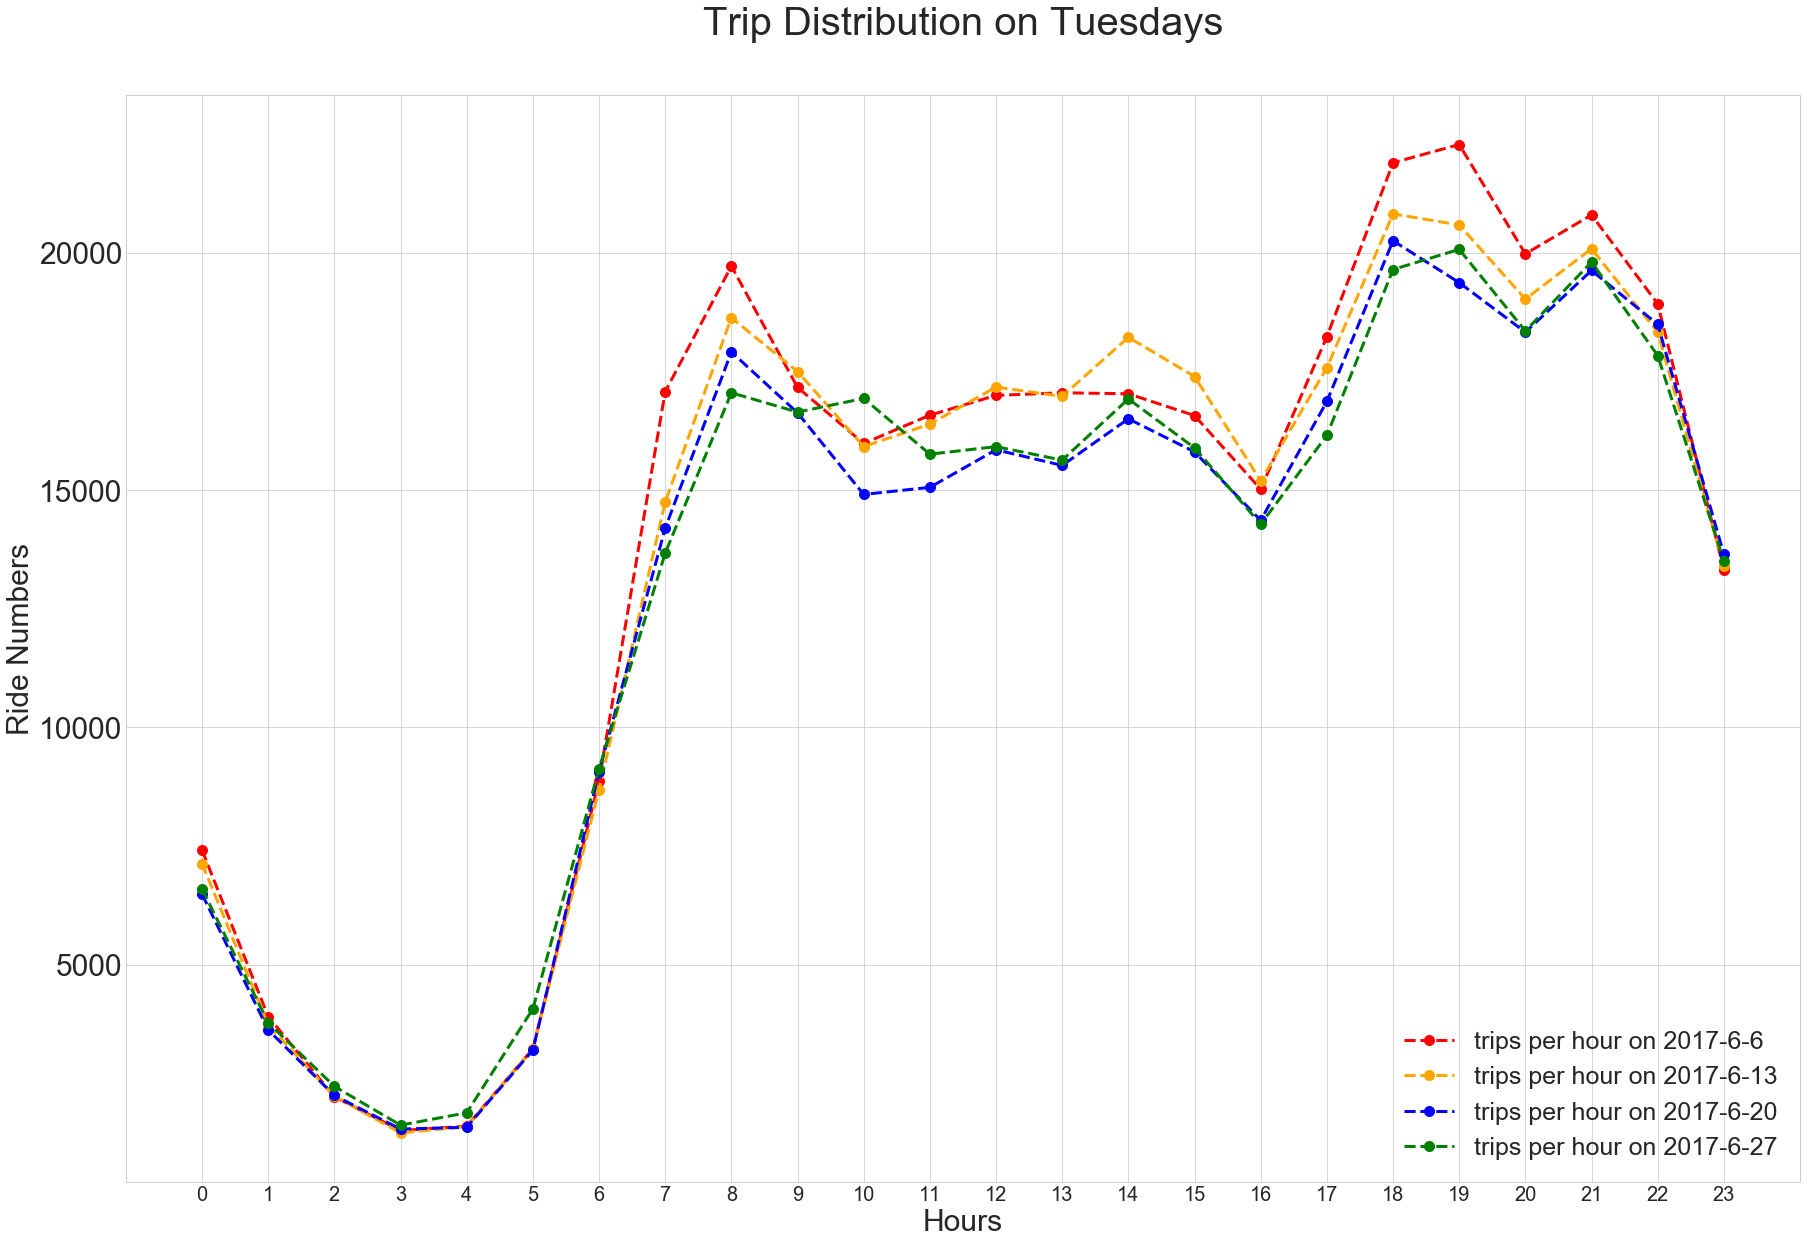

In [119]:
df_t['date'] = df_t['pu_dates'].dt.date
df_t1 = df_t[df_t['date'] == datetime.date(2017, 6, 6)]
df_t2 = df_t[df_t['date'] == datetime.date(2017, 6, 13)]
df_t3 = df_t[df_t['date'] == datetime.date(2017, 6, 20)]
df_t4 = df_t[df_t['date'] == datetime.date(2017, 6, 27)]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

colors = ['red', 'orange', 'blue', 'green']
dates = ['2017-6-6', '2017-6-13', '2017-6-20', '2017-6-27']
dfs = [df_t1, df_t2, df_t3, df_t4]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(4):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Tuesdays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [120]:
df_t_hour89 = pd.DataFrame(df_t[(df_t['hour'] == 8) | (df_t['hour'] == 9)].groupby(['PULocationID']).size())
df_t_hour7 = pd.DataFrame(df_t[(df_t['hour'] == 7)].groupby(['PULocationID']).size())
df_t_hour1819 = pd.DataFrame(df_t[(df_t['hour'] == 18) | (df_t['hour'] == 19)].groupby(['PULocationID']).size())
df_t_hour34 = pd.DataFrame(df_t[(df_t['hour'] == 3) | (df_t['hour'] == 4)].groupby(['PULocationID']).size())
df_t_hour2223 = pd.DataFrame(df_t[(df_t['hour'] == 22) | (df_t['hour'] == 23)].groupby(['PULocationID']).size())

df_t_hour34.columns = ['Count']
df_t_hour89.columns = ['Count']
df_t_hour1819.columns = ['Count']
df_t_hour2223.columns = ['Count']
df_t_hour7.columns = ['Count']

lst1 = []
lst2 = []
for i in df_t_hour89.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_t_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_t_hour34.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])

lst7 = []
lst8 = []
for i in df_t_hour2223.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
lst9 = []
lst10 = []
for i in df_t_hour7.index:
    for j in df1.LocationID:
        if i == j:
            lst9.append(df1['Borough'].iloc[j-1])
            lst10.append(df1['Zone'].iloc[j-1])
            
#df_m1[df_m1['hour'] == 0].groupby(['PULocationID']).size()
df_t_hour89['Borough'] = lst1
df_t_hour89['Zone'] = lst2

df_t_hour1819['Borough'] = lst3
df_t_hour1819['Zone'] = lst4

df_t_hour34['Borough'] = lst5
df_t_hour34['Zone'] = lst6

df_t_hour2223['Borough'] = lst7
df_t_hour2223['Zone'] = lst8

df_t_hour7['Borough'] = lst9
df_t_hour7['Zone'] = lst10

In [253]:
idxt89 = df_t_hour89.sort_values(by='Count', ascending=False)
#idxt89.to_csv('tuesdays89.csv')
idxt89.head(5)

,Count,Borough,Zone
PULocationID,,,
236,7575,Manhattan,Upper East Side North
237,7468,Manhattan,Upper East Side South
170,5569,Manhattan,Murray Hill
186,5548,Manhattan,Penn Station/Madison Sq West
162,5018,Manhattan,Midtown East


In [255]:
dft89 = df_t1[(df_t1['hour'] == 8) | (df_t1['hour'] == 9)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxt89.index:
    
    avgf = dft89[dft89['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dft89[dft89['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dft89[dft89['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
tuesdays89 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxt89.Zone)

#tuesdays89.to_csv('tuesdays_report89.csv')
tuesdays89.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side North,13.697986,1.908895,14.714785,7.18,0.93,0.13
Upper East Side South,11.391082,1.485786,11.584303,7.67,0.98,0.13
Murray Hill,12.572084,1.622038,12.997777,7.75,0.97,0.12
Penn Station/Madison Sq West,14.334728,1.769886,16.506021,8.10,0.87,0.11
Midtown East,12.992883,1.823933,13.400795,7.12,0.97,0.14


In [256]:
print(tuesdays89['Average Fare per mile'].head(55).mean())
print(tuesdays89['Average Fare per minute'].head(55).mean())
print(tuesdays89['Average Distance per minute'].head(55).mean())

6.610363636363637
0.966
0.15018181818181822


In [257]:
idxt1819 = df_t_hour1819.sort_values(by='Count', ascending=False)
#idxt1819.to_csv('tuesdays1819.csv')
idxt1819.head(5)

,Count,Borough,Zone
PULocationID,,,
237,8365,Manhattan,Upper East Side South
161,7966,Manhattan,Midtown Center
162,7423,Manhattan,Midtown East
234,6874,Manhattan,Union Sq
236,6561,Manhattan,Upper East Side North


In [259]:
dft1819 = df_t1[(df_t1['hour'] == 18) | (df_t1['hour'] == 19)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxt1819.index:
    
    avgf = dft1819[dft1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dft1819[dft1819['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dft1819[dft1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
tuesdays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxt1819.Zone)

#tuesdays1819.to_csv('tuesdays_report1819.csv')
tuesdays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side South,12.829643,1.761583,11.498833,7.28,1.12,0.15
Midtown Center,14.901819,2.059343,14.498841,7.24,1.03,0.14
Midtown East,14.671165,2.067675,13.729124,7.10,1.07,0.15
Union Sq,14.085240,1.895468,13.339199,7.43,1.06,0.14
Upper East Side North,12.138889,1.675230,10.254477,7.25,1.18,0.16


In [260]:
print(tuesdays1819['Average Fare per mile'].head(55).mean())
print(tuesdays1819['Average Fare per minute'].head(55).mean())
print(tuesdays1819['Average Distance per minute'].head(55).mean())

6.533090909090909
1.1363636363636365
0.17963636363636365


In [261]:
idxt34 = df_t_hour34.sort_values(by='Count', ascending=False)
#idxt34.to_csv('tuesdays34.csv')
idxt34.head()

,Count,Borough,Zone
PULocationID,,,
48,799,Manhattan,Clinton East
230,771,Manhattan,Times Sq/Theatre District
79,751,Manhattan,East Village
132,611,Queens,JFK Airport
68,607,Manhattan,East Chelsea


In [262]:
dft34 = df_t1[(df_t1['hour'] == 3) | (df_t1['hour'] == 4)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxt34.index:
    
    avgf = dft34[dft34['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dft34[dft34['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dft34[dft34['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
tuesdays34 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxt34.Zone)

#tuesdays34.to_csv('tuesdays_report34.csv')
tuesdays34.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Clinton East,14.787970,3.385990,10.884736,4.37,1.36,0.31
Times Sq/Theatre District,17.867579,4.330263,12.126842,4.13,1.47,0.36
East Village,16.596277,3.935745,11.942465,4.22,1.39,0.33
JFK Airport,45.186016,13.890569,22.323306,3.25,2.02,0.62
East Chelsea,14.806115,3.152014,10.709472,4.70,1.38,0.29


In [263]:
print(tuesdays34['Average Fare per mile'].head(55).mean())
print(tuesdays34['Average Fare per minute'].head(55).mean())
print(tuesdays34['Average Distance per minute'].head(55).mean())

4.338363636363637
1.5278181818181822
0.35672727272727267


In [268]:
idxt2223 = df_t_hour2223.sort_values(by='Count', ascending=False)
#idxt2223.to_csv('tuesdays2223.csv')
idxt2223.head()

,Count,Borough,Zone
PULocationID,,,
161,6213,Manhattan,Midtown Center
230,6148,Manhattan,Times Sq/Theatre District
234,5223,Manhattan,Union Sq
79,5150,Manhattan,East Village
142,4811,Manhattan,Lincoln Square East


In [265]:
dft2223 = df_t1[(df_t1['hour'] == 22) | (df_t1['hour'] == 23)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxt2223.index:
    
    avgf = dft2223[dft2223['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dft2223[dft2223['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dft2223[dft2223['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
tuesdays2223 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxt2223.Zone)

#tuesdays2223.to_csv('tuesdays_report2223.csv')
tuesdays2223.head()


,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Midtown Center,14.121185,2.532329,11.394595,5.58,1.24,0.22
Times Sq/Theatre District,14.359340,2.590377,12.164714,5.54,1.18,0.21
Union Sq,14.054800,2.520461,11.689171,5.58,1.20,0.22
East Village,14.454400,2.620600,12.468528,5.52,1.16,0.21
Lincoln Square East,14.427958,2.604308,12.682836,5.54,1.14,0.21


In [269]:
print(tuesdays2223['Average Fare per mile'].head(55).mean())
print(tuesdays2223['Average Fare per minute'].head(55).mean())
print(tuesdays2223['Average Distance per minute'].head(55).mean())

5.184909090909092
1.2503636363636363
0.2450909090909091


In [270]:
idxt7 = df_t_hour7.sort_values(by='Count', ascending=False)
#idxt7.to_csv('tuesdays7.csv')
idxt7.head()

,Count,Borough,Zone
PULocationID,,,
186,3476,Manhattan,Penn Station/Madison Sq West
236,2903,Manhattan,Upper East Side North
237,2588,Manhattan,Upper East Side South
48,2237,Manhattan,Clinton East
162,2183,Manhattan,Midtown East


In [271]:
dft7 = df_t1[(df_t1['hour'] == 7)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxt7.index:
    
    avgf = dft7[dft7['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dft7[dft7['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dft7[dft7['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
tuesdays7 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxt7.Zone)

#tuesdays7.to_csv('tuesdays_report7.csv')
tuesdays7.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Penn Station/Madison Sq West,11.120230,1.608676,10.965354,6.91,1.01,0.15
Upper East Side North,13.017190,2.186361,12.164510,5.95,1.07,0.18
Upper East Side South,11.097660,1.699966,10.091282,6.53,1.10,0.17
Clinton East,10.400318,1.584776,9.480608,6.56,1.10,0.17
Midtown East,11.710014,1.815864,10.254178,6.45,1.14,0.18


In [272]:
print(tuesdays7['Average Fare per mile'].head(55).mean())
print(tuesdays7['Average Fare per minute'].head(55).mean())
print(tuesdays7['Average Distance per minute'].head(55).mean())

5.7807272727272725
1.0758181818181818
0.18872727272727272


# Wednesday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


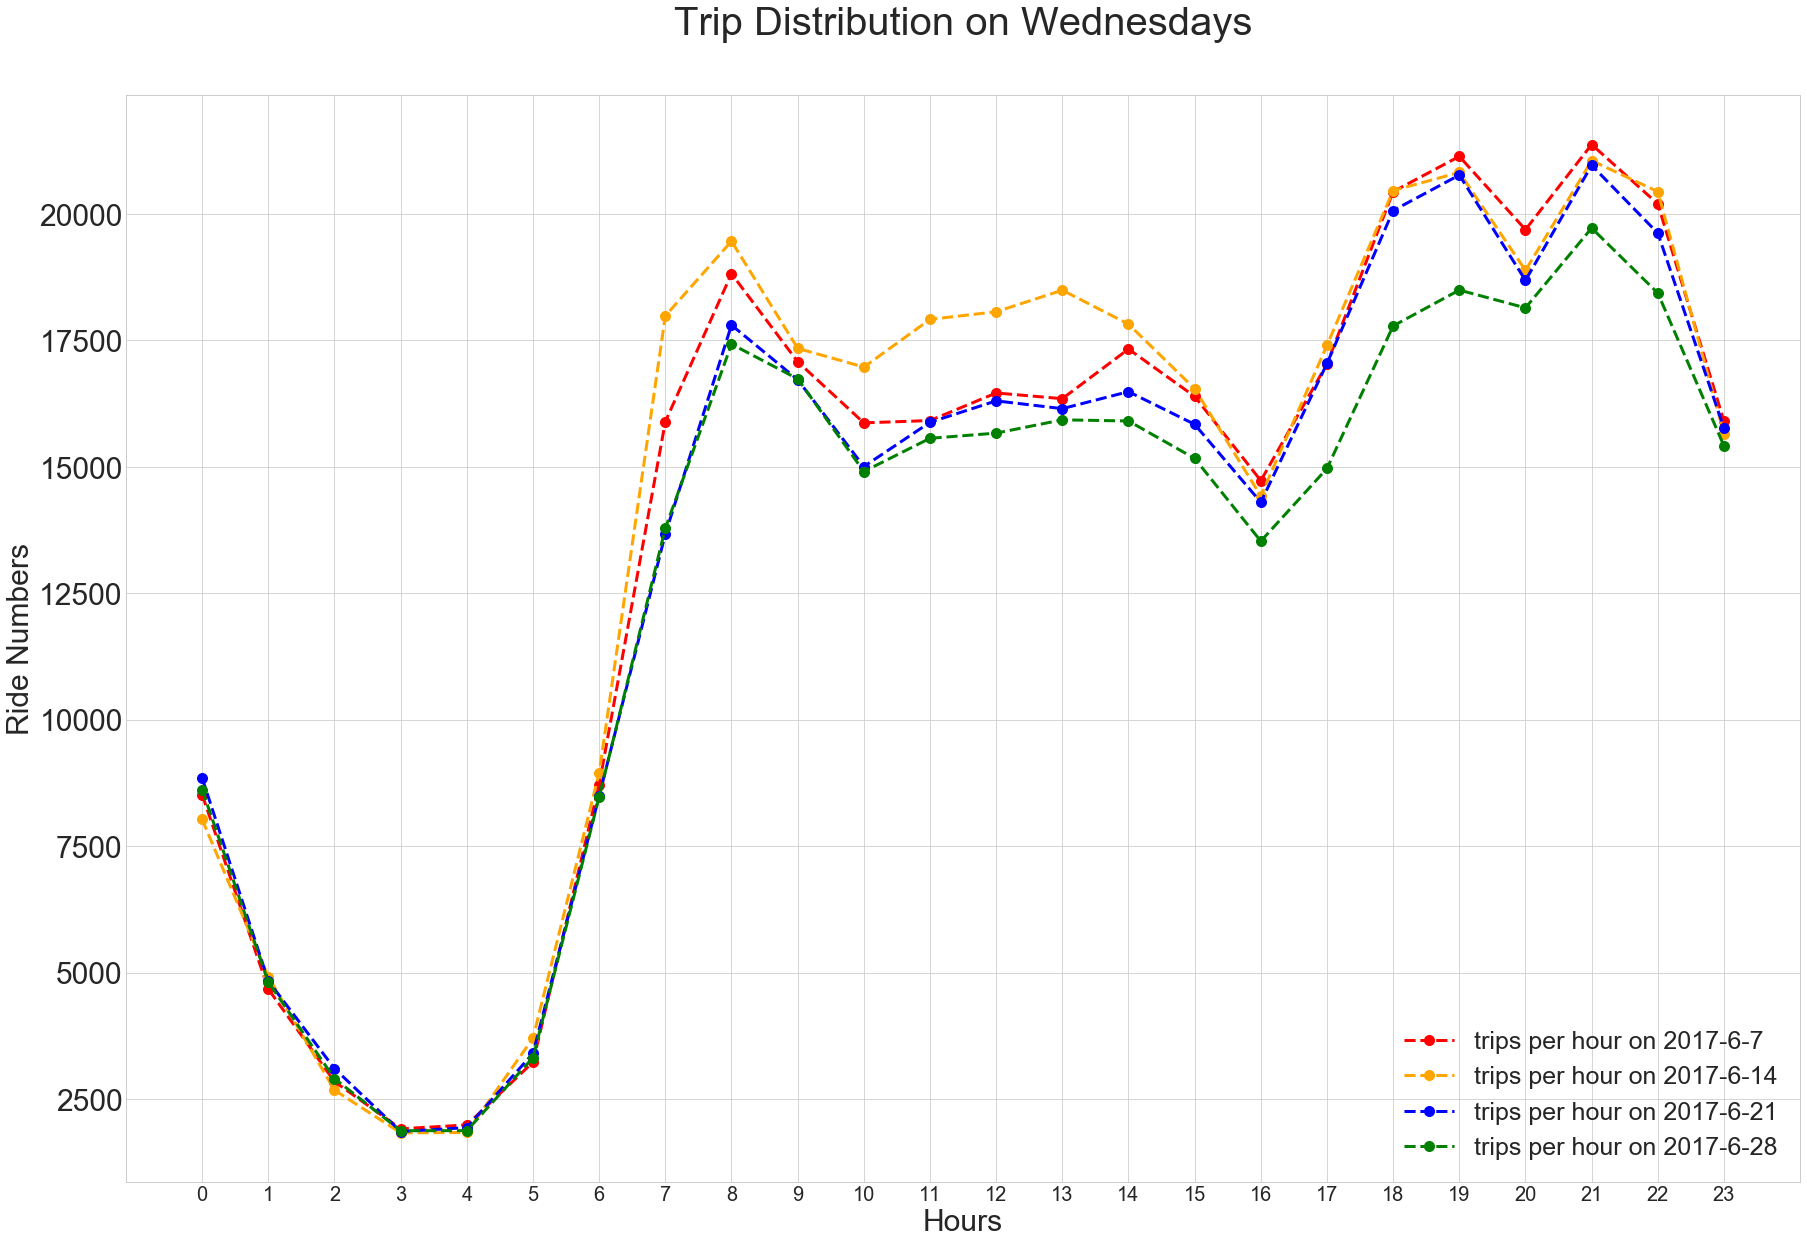

In [39]:
df_w['date'] = df_w['pu_dates'].dt.date
df_w1 = df_w[df_w['date'] == datetime.date(2017, 6, 7)]
df_w2 = df_w[df_w['date'] == datetime.date(2017, 6, 14)]
df_w3 = df_w[df_w['date'] == datetime.date(2017, 6, 21)]
df_w4 = df_w[df_w['date'] == datetime.date(2017, 6, 28)]

colors = ['red', 'orange', 'blue', 'green']
dates = ['2017-6-7', '2017-6-14', '2017-6-21', '2017-6-28']
dfs = [df_w1, df_w2, df_w3, df_w4]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(4):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Wednesdays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [295]:
df_w_hour89 = pd.DataFrame(df_w[(df_w['hour'] == 8) | (df_w['hour'] == 9)].groupby(['PULocationID']).size())
df_w_hour1819 = pd.DataFrame(df_w[(df_w['hour'] == 18) | (df_w['hour'] == 19)].groupby(['PULocationID']).size())
df_w_hour2122 = pd.DataFrame(df_w[(df_w['hour'] == 21) | (df_w['hour'] == 22)].groupby(['PULocationID']).size())
df_w_hour34 = pd.DataFrame(df_w[(df_w['hour'] == 3) | (df_w['hour'] == 4)].groupby(['PULocationID']).size())
df_w_hour20 = pd.DataFrame(df_w[df_w['hour'] == 20].groupby(['PULocationID']).size())

df_w_hour20.columns = ['Count']
df_w_hour34.columns = ['Count']
df_w_hour89.columns = ['Count']
df_w_hour1819.columns = ['Count']
df_w_hour2122.columns = ['Count']

lst1 = []
lst2 = []
for i in df_w_hour89.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_w_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_w_hour34.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])

lst7 = []
lst8 = []
for i in df_w_hour2122.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
lst9 = []
lst10 = []
for i in df_w_hour20.index:
    for j in df1.LocationID:
        if i == j:
            lst9.append(df1['Borough'].iloc[j-1])
            lst10.append(df1['Zone'].iloc[j-1])
            
#df_m1[df_m1['hour'] == 0].groupby(['PULocationID']).size()
df_w_hour89['Borough'] = lst1
df_w_hour89['Zone'] = lst2

df_w_hour1819['Borough'] = lst3
df_w_hour1819['Zone'] = lst4

df_w_hour34['Borough'] = lst5
df_w_hour34['Zone'] = lst6

df_w_hour2122['Borough'] = lst7
df_w_hour2122['Zone'] = lst8

df_w_hour20['Borough'] = lst9
df_w_hour20['Zone'] = lst10

In [296]:
idxw89 = df_w_hour89.sort_values(by='Count', ascending=False)
#idxw89.to_csv('wednesdays89.csv')
idxw89.head()

,Count,Borough,Zone
PULocationID,,,
236,7369,Manhattan,Upper East Side North
237,7228,Manhattan,Upper East Side South
186,5733,Manhattan,Penn Station/Madison Sq West
170,5604,Manhattan,Murray Hill
162,4708,Manhattan,Midtown East


In [297]:
dfw89 = df_w1[(df_w1['hour'] == 8) | (df_w1['hour'] == 9)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxw89.index:
    
    avgf = dfw89[dfw89['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfw89[dfw89['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dfw89[dfw89['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
wednesdays89 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxw89.Zone)

#wednesdays89.to_csv('wednesdays_report89.csv')
wednesdays89.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side North,13.474503,1.920588,14.111427,7.02,0.95,0.14
Upper East Side South,11.750897,1.539311,11.935776,7.63,0.98,0.13
Penn Station/Madison Sq West,13.941660,1.779444,15.496528,7.83,0.90,0.11
Murray Hill,12.579835,1.648461,12.840098,7.63,0.98,0.13
Midtown East,13.689850,1.986458,14.048403,6.89,0.97,0.14


In [298]:
print(wednesdays89['Average Fare per mile'].head(55).mean())
print(wednesdays89['Average Fare per minute'].head(55).mean())
print(wednesdays89['Average Distance per minute'].head(55).mean())

6.421090909090909
0.9907272727272727
0.15818181818181815


In [299]:
idxw1819 = df_w_hour1819.sort_values(by='Count', ascending=False)
#idxw1819.to_csv('wednesdays1819.csv')
idxw1819.head()

,Count,Borough,Zone
PULocationID,,,
237,8236,Manhattan,Upper East Side South
161,7445,Manhattan,Midtown Center
162,7167,Manhattan,Midtown East
234,6510,Manhattan,Union Sq
236,6405,Manhattan,Upper East Side North


In [300]:
dfw1819 = df_w[(df_w['hour'] == 18) | (df_w['hour'] == 19)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxw1819.index:
    
    avgf = dfw1819[dfw1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfw1819[dfw1819['PULocationID'] == i]['trip_distance'].mean()
    avgds.append(avgd)
    
    avgt = dfw1819[dfw1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
wednesdays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxw1819.Zone)

#wednesdays1819.to_csv('wednesdays_report1819.csv')
wednesdays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side South,13.009298,1.700722,12.060462,7.65,1.08,0.14
Midtown Center,16.169584,2.147547,16.770815,7.53,0.96,0.13
Midtown East,15.523110,2.144436,15.337919,7.24,1.01,0.14
Union Sq,14.350086,1.858300,13.966982,7.72,1.03,0.13
Upper East Side North,12.679594,1.734373,11.191671,7.31,1.13,0.15


In [301]:
print(wednesdays1819['Average Fare per mile'].head(55).mean())
print(wednesdays1819['Average Fare per minute'].head(55).mean())
print(wednesdays1819['Average Distance per minute'].head(55).mean())

6.738
1.071636363636364
0.16399999999999998


In [305]:
idxw2122 = df_w_hour2122.sort_values(by='Count', ascending=False)
#idxw2122.to_csv('wednesdays2122.csv')
idxw2122.head()

,Count,Borough,Zone
PULocationID,,,
161,7342,Manhattan,Midtown Center
162,6890,Manhattan,Midtown East
230,6684,Manhattan,Times Sq/Theatre District
234,6026,Manhattan,Union Sq
142,5849,Manhattan,Lincoln Square East


In [307]:
dfw2122 = df_w[(df_w['hour'] == 21) | (df_w['hour'] == 22)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxw2122.index:
    
    avgf = dfw2122[dfw2122['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfw2122[dfw2122['PULocationID'] == i]['trip_distance'].mean()    
    avgds.append(avgd)
    
    avgt = dfw2122[dfw2122['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
wednesdays2122 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxw2122.Zone)

#wednesdays2122.to_csv('wednesdays_report2122.csv')
wednesdays2122.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Midtown Center,14.451407,2.474028,12.640938,5.84,1.14,0.20
Midtown East,14.520292,2.554774,12.298111,5.68,1.18,0.21
Times Sq/Theatre District,14.643900,2.567362,13.074107,5.70,1.12,0.20
Union Sq,14.580679,2.507919,13.142073,5.81,1.11,0.19
Lincoln Square East,13.893669,2.468405,12.181484,5.63,1.14,0.20


In [308]:
print(wednesdays2122['Average Fare per mile'].head(55).mean())
print(wednesdays2122['Average Fare per minute'].head(55).mean())
print(wednesdays2122['Average Distance per minute'].head(55).mean())

5.3609090909090895
1.1874545454545455
0.22563636363636363


# Thursday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


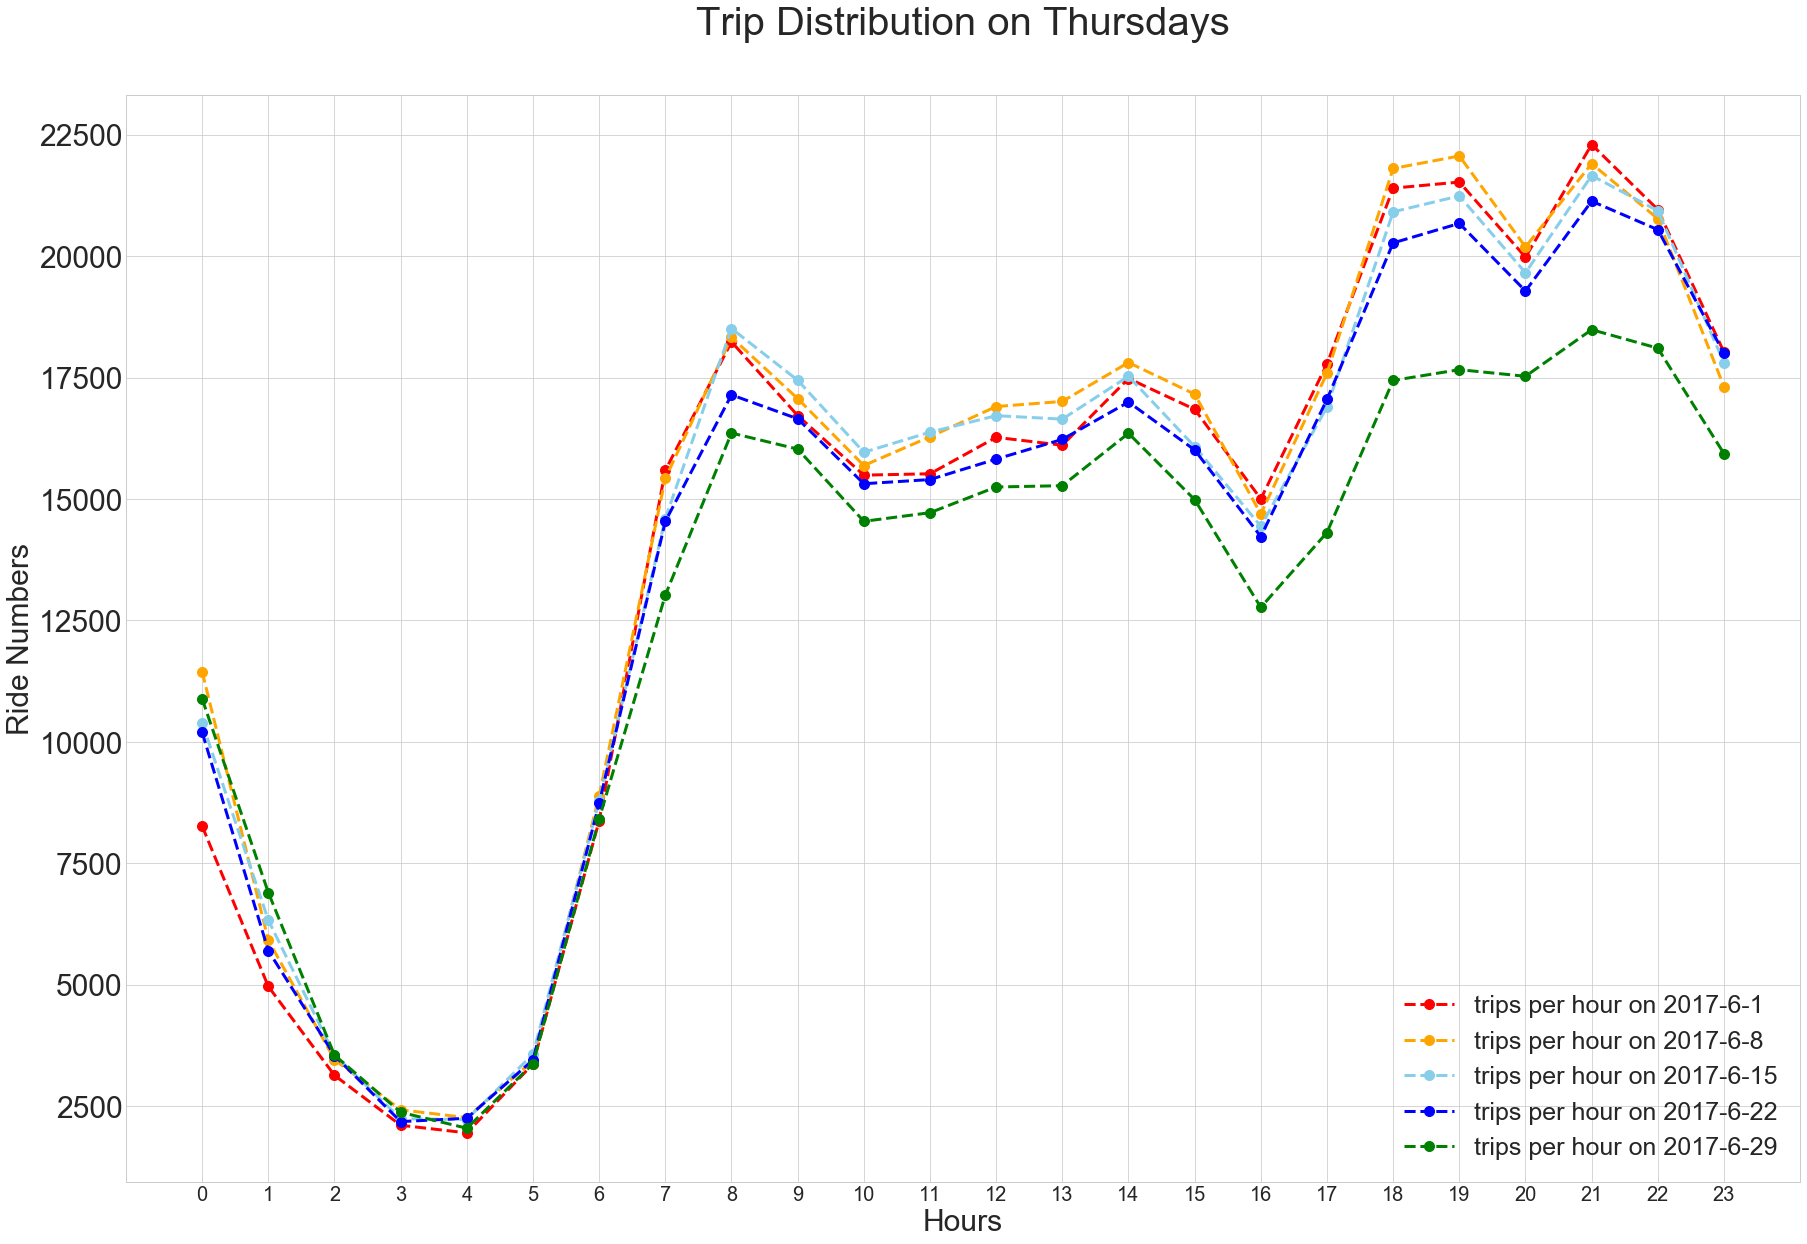

In [58]:
df_th['date'] = df_th['pu_dates'].dt.date
df_th1 = df_th[df_th['date'] == datetime.date(2017, 6, 1)]
df_th2 = df_th[df_th['date'] == datetime.date(2017, 6, 8)]
df_th3 = df_th[df_th['date'] == datetime.date(2017, 6, 15)]
df_th4 = df_th[df_th['date'] == datetime.date(2017, 6, 22)]
df_th5 = df_th[df_th['date'] == datetime.date(2017, 6, 29)]

colors = ['red', 'orange', 'skyblue', 'blue', 'green']
dates = ['2017-6-1', '2017-6-8', '2017-6-15', '2017-6-22', '2017-6-29']
dfs = [df_th1, df_th2, df_th3, df_th4, df_th5]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(5):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Thursdays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [310]:
df_th_hour89 = pd.DataFrame(df_th[(df_th['hour'] == 8) | (df_th['hour'] == 9)].groupby(['PULocationID']).size())
df_th_hour1819 = pd.DataFrame(df_th[(df_th['hour'] == 18) | (df_th['hour'] == 19)].groupby(['PULocationID']).size())
df_th_hour2122 = pd.DataFrame(df_th[(df_th['hour'] == 21) | (df_th['hour'] == 22)].groupby(['PULocationID']).size())
df_th_hour34 = pd.DataFrame(df_th[(df_th['hour'] == 3) | (df_th['hour'] == 4)].groupby(['PULocationID']).size())
df_th_hour1012 = pd.DataFrame(df_th[(df_th['hour'] == 10) | (df_th['hour'] == 12)].groupby(['PULocationID']).size())

df_th_hour34.columns = ['Count']
df_th_hour89.columns = ['Count']
df_th_hour1819.columns = ['Count']
df_th_hour2122.columns = ['Count']
df_th_hour1012.columns = ['Count']

lst1 = []
lst2 = []
for i in df_th_hour89.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_th_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_th_hour34.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])

lst7 = []
lst8 = []
for i in df_th_hour2122.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
lst9 = []
lst10 = []
for i in df_th_hour1012.index:
    for j in df1.LocationID:
        if i == j:
            lst9.append(df1['Borough'].iloc[j-1])
            lst10.append(df1['Zone'].iloc[j-1])

            
#df_m1[df_m1['hour'] == 0].groupby(['PULocationID']).size()
df_th_hour89['Borough'] = lst1
df_th_hour89['Zone'] = lst2

df_th_hour1819['Borough'] = lst3
df_th_hour1819['Zone'] = lst4

df_th_hour34['Borough'] = lst5
df_th_hour34['Zone'] = lst6

df_th_hour2122['Borough'] = lst7
df_th_hour2122['Zone'] = lst8

df_th_hour1012['Borough'] = lst9
df_th_hour1012['Zone'] = lst10

In [311]:
idxth89 = df_th_hour89.sort_values(by='Count', ascending=False)
#idxth89.to_csv('thursday89.csv')
idxth89.head()

,Count,Borough,Zone
PULocationID,,,
236,9040,Manhattan,Upper East Side North
237,8905,Manhattan,Upper East Side South
170,7006,Manhattan,Murray Hill
186,6945,Manhattan,Penn Station/Madison Sq West
162,6075,Manhattan,Midtown East


In [312]:
dfth89 = df_th[(df_th['hour'] == 8) | (df_th['hour'] == 9)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxth89.index:
    
    avgf = dfth89[dfth89['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfth89[dfth89['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfth89[dfth89['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
thursdays89 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxth89.Zone)

#thursdays89.to_csv('thursdays_report89.csv')
thursdays89.head()

C:\Python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side North,12.954983,2.001261,12.785238,6.47,1.01,0.16
Upper East Side South,11.164759,1.567444,10.761269,7.12,1.04,0.15
Murray Hill,13.248860,1.851960,13.384285,7.15,0.99,0.14
Penn Station/Madison Sq West,14.582919,1.852628,16.456559,7.87,0.89,0.11
Midtown East,13.846649,2.109188,13.734173,6.56,1.01,0.15


In [313]:
print(thursdays89['Average Fare per mile'].head(55).mean())
print(thursdays89['Average Fare per minute'].head(55).mean())
print(thursdays89['Average Distance per minute'].head(55).mean())

6.292363636363636
0.9947272727272728
0.16145454545454543


In [314]:
idxth1819 = df_th_hour1819.sort_values(by='Count', ascending=False)
#idxth1819.to_csv('thursday1819.csv')
idxth1819.head(10)

,Count,Borough,Zone
PULocationID,,,
237,9925,Manhattan,Upper East Side South
161,9090,Manhattan,Midtown Center
162,9014,Manhattan,Midtown East
234,8307,Manhattan,Union Sq
236,8016,Manhattan,Upper East Side North
170,7675,Manhattan,Murray Hill
163,7307,Manhattan,Midtown North
230,6883,Manhattan,Times Sq/Theatre District
138,6453,Queens,LaGuardia Airport


In [315]:
dfth1819 = df_th[(df_th['hour'] == 18) | (df_th['hour'] == 19)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxth1819.index:
    
    avgf = dfth1819[dfth1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfth1819[dfth1819['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfth1819[dfth1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
thursdays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxth1819.Zone)

#thursdays1819.to_csv('thursdays_report1819.csv')
thursdays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side South,13.024567,1.724631,12.046934,7.55,1.08,0.14
Midtown Center,15.866234,2.106590,16.325502,7.53,0.97,0.13
Midtown East,15.657308,2.159527,15.477822,7.25,1.01,0.14
Union Sq,14.541942,1.877570,14.192083,7.75,1.02,0.13
Upper East Side North,12.972745,1.809368,11.591276,7.17,1.12,0.16


In [316]:
print(thursdays1819['Average Fare per mile'].head(55).mean())
print(thursdays1819['Average Fare per minute'].head(55).mean())
print(thursdays1819['Average Distance per minute'].head(55).mean())

6.770181818181817
1.0583636363636362
0.1601818181818182


In [319]:
idxth2122 = df_th_hour2122.sort_values(by='Count', ascending=False)
#idxth2122.to_csv('thursday2122.csv')
idxth2122.head()

,Count,Borough,Zone
PULocationID,,,
162,8837,Manhattan,Midtown East
161,8695,Manhattan,Midtown Center
142,8185,Manhattan,Lincoln Square East
48,8105,Manhattan,Clinton East
79,7845,Manhattan,East Village


In [69]:
dfth2122 = df_th[(df_th['hour'] == 21) | (df_th['hour'] == 22)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxth2122.index:
    
    avgf = dfth2122[dfth2122['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfth2122[dfth2122['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfth2122[dfth2122['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
thursdays2122 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxth2122.Zone)

#thursdays2122.to_csv('thursdays_report2122.csv')
thursdays2122.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Midtown East,14.753964,2.517733,12.959930,5.86,1.14,0.19
Midtown Center,14.783691,2.506542,13.406538,5.90,1.10,0.19
Lincoln Square East,14.189823,2.472857,13.006761,5.74,1.09,0.19
Clinton East,14.967127,2.625617,13.642791,5.70,1.10,0.19
East Village,15.130745,2.565352,14.193342,5.90,1.07,0.18
Union Sq,14.786476,2.474541,13.813985,5.98,1.07,0.18
Times Sq/Theatre District,14.903452,2.549221,14.054891,5.85,1.06,0.18
Upper East Side South,12.744491,2.144492,10.855819,5.94,1.17,0.20
Murray Hill,14.606819,2.486889,13.018751,5.87,1.12,0.19


In [320]:
print(thursdays2122['Average Fare per mile'].head(55).mean())
print(thursdays2122['Average Fare per minute'].head(55).mean())
print(thursdays2122['Average Distance per minute'].head(55).mean())

5.482
1.1358181818181816
0.21036363636363636


In [321]:
df_th_hourr = pd.DataFrame(df_th[(df_th['hour'] == 10) | (df_th['hour'] == 12)].groupby(['PULocationID']).size())
df_th_hourr.columns = ['Count']

lstr1 = []
lstr2 = []
for i in df_th_hourr.index:
    for j in df1.LocationID:
        if i == j:
            lstr1.append(df1['Borough'].iloc[j-1])
            lstr2.append(df1['Zone'].iloc[j-1])
            
df_th_hourr['Borough'] = lstr1
df_th_hourr['Zone'] = lstr2

idxthr = df_th_hourr.sort_values(by='Count', ascending=False)
idxthr.head()

,Count,Borough,Zone
PULocationID,,,
237,8479,Manhattan,Upper East Side South
236,8174,Manhattan,Upper East Side North
161,7843,Manhattan,Midtown Center
162,6234,Manhattan,Midtown East
170,6177,Manhattan,Murray Hill


In [322]:
dfthr = df_th[(df_th['hour'] == 10) | (df_th['hour'] == 12)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxthr.index:
    
    avgf = dfthr[dfthr['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfthr[dfthr['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfthr[dfthr['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
thursdays1012 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxthr.Zone)

#thursdays1012.to_csv('thursdays_report1012.csv')
thursdays1012.head()


,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side South,12.048272,1.626930,12.511086,7.41,0.96,0.13
Upper East Side North,12.200612,1.753270,12.498770,6.96,0.98,0.14
Midtown Center,15.135870,2.313092,15.722392,6.54,0.96,0.15
Midtown East,15.444538,2.393442,15.845535,6.45,0.97,0.15
Murray Hill,14.498883,2.054029,15.384485,7.06,0.94,0.13


In [323]:
print(thursdays1012['Average Fare per mile'].head(55).mean())
print(thursdays1012['Average Fare per minute'].head(55).mean())
print(thursdays1012['Average Distance per minute'].head(55).mean())

6.40818181818182
0.9569090909090909
0.15509090909090908


# Friday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


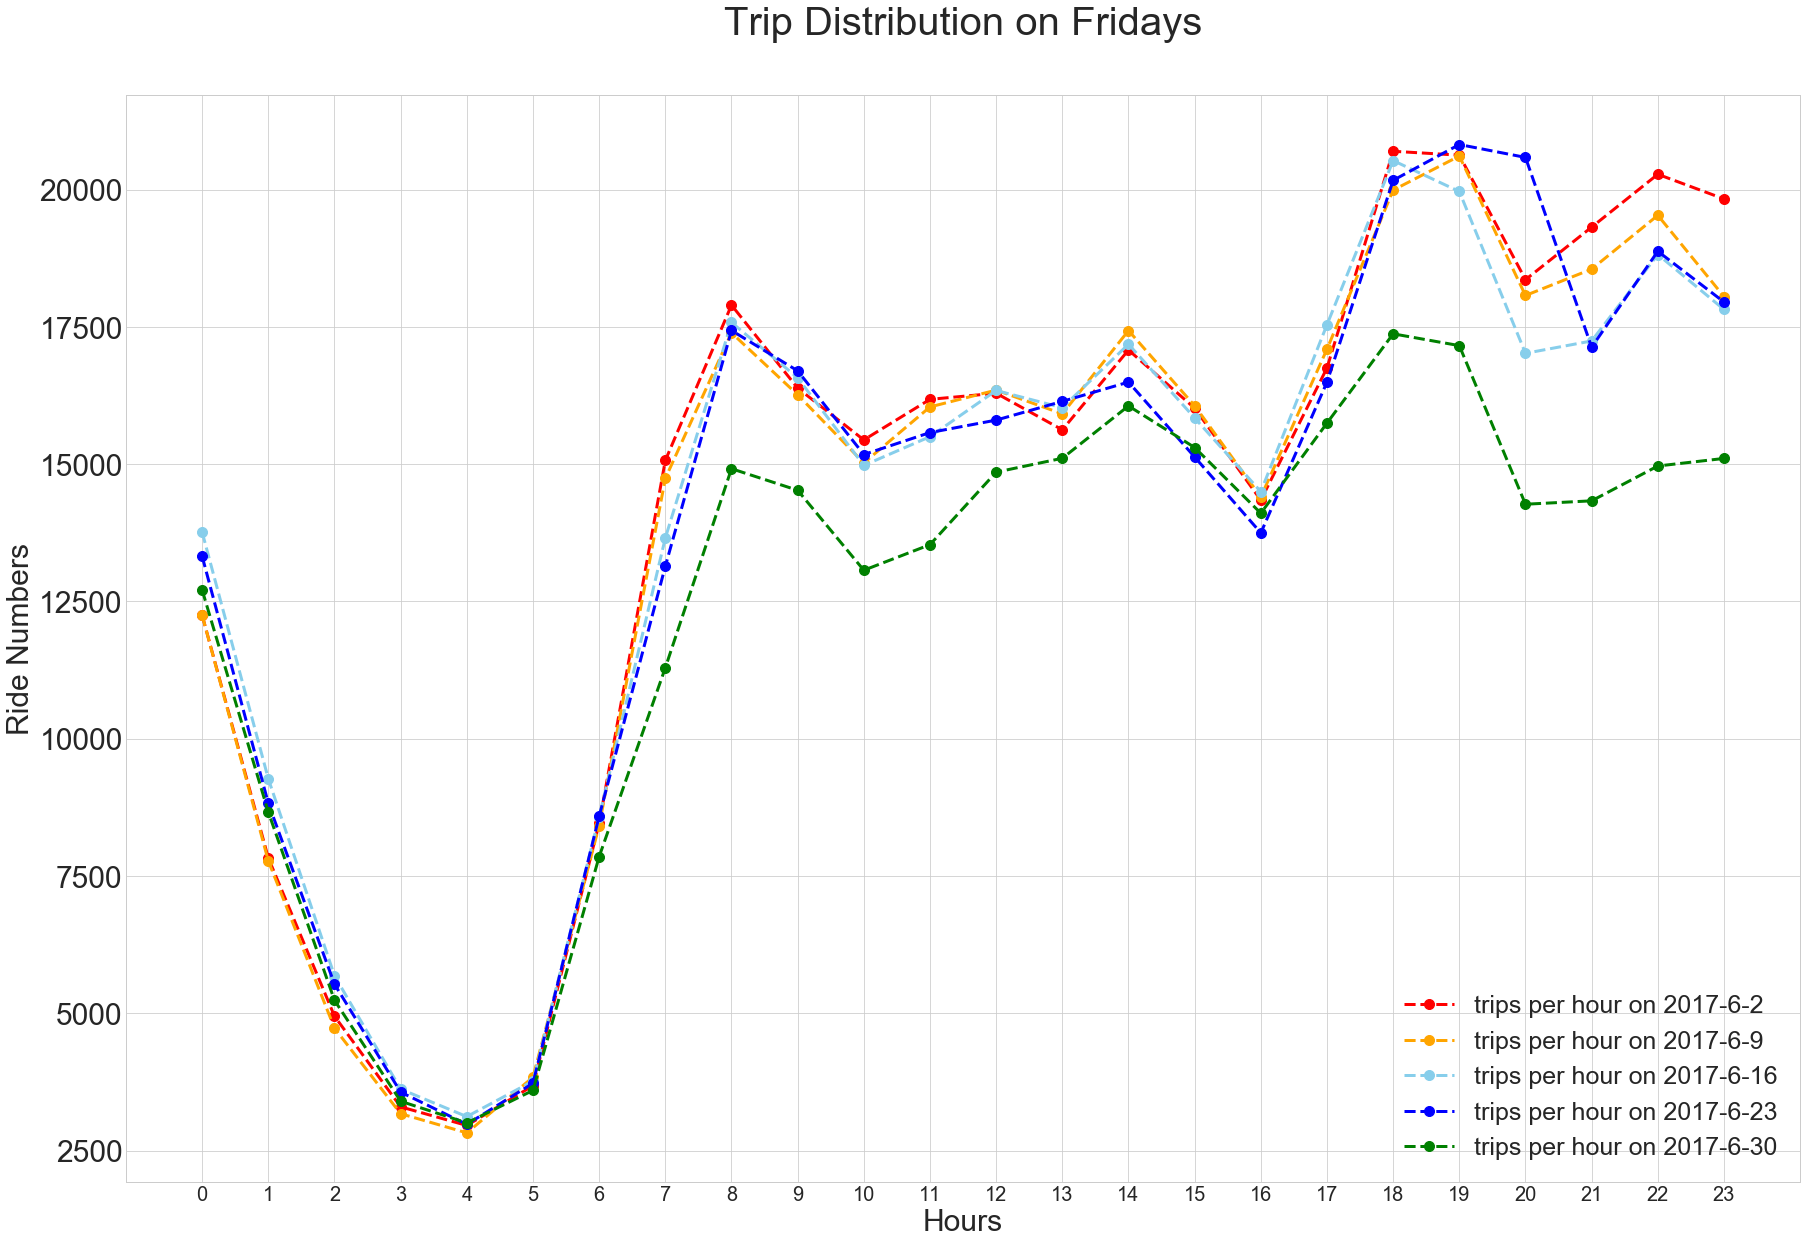

In [74]:
df_f['date'] = df_f['pu_dates'].dt.date
df_f1 = df_f[df_f['date'] == datetime.date(2017, 6, 2)]
df_f2 = df_f[df_f['date'] == datetime.date(2017, 6, 9)]
df_f3 = df_f[df_f['date'] == datetime.date(2017, 6, 16)]
df_f4 = df_f[df_f['date'] == datetime.date(2017, 6, 23)]
df_f5 = df_f[df_f['date'] == datetime.date(2017, 6, 30)]

colors = ['red', 'orange', 'skyblue', 'blue', 'green']
dates = ['2017-6-2', '2017-6-9', '2017-6-16', '2017-6-23', '2017-6-30']
dfs = [df_f1, df_f2, df_f3, df_f4, df_f5]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(5):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Fridays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [77]:
df_f_hour89 = pd.DataFrame(df_f[(df_f['hour'] == 8) | (df_f['hour'] == 9)].groupby(['PULocationID']).size())
df_f_hour2223 = pd.DataFrame(df_f[(df_f['hour'] == 22) | (df_f['hour'] == 23)].groupby(['PULocationID']).size())
df_f_hour20 = pd.DataFrame(df_f[(df_f['hour'] == 20)].groupby(['PULocationID']).size())
df_f_hour1819 = pd.DataFrame(df_f[(df_f['hour'] == 18) | (df_f['hour'] == 19)].groupby(['PULocationID']).size())
df_f_hour2122 = pd.DataFrame(df_f[(df_f['hour'] == 21) | (df_f['hour'] == 22)].groupby(['PULocationID']).size())
df_f_hour01 = pd.DataFrame(df_f[(df_f['hour'] == 0) | (df_f['hour'] == 1)].groupby(['PULocationID']).size())

df_f_hour89.columns = ['Count']
df_f_hour1819.columns = ['Count']
df_f_hour2223.columns = ['Count']
df_f_hour20.columns = ['Count']
df_f_hour2122.columns = ['Count']
df_f_hour01.columns = ['Count']

lst1 = []
lst2 = []
for i in df_f_hour89.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_f_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_f_hour2223.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])
            
lst7 = []
lst8 = []
for i in df_f_hour20.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
lst9 = []
lst10 = []
for i in df_f_hour2122.index:
    for j in df1.LocationID:
        if i == j:
            lst9.append(df1['Borough'].iloc[j-1])
            lst10.append(df1['Zone'].iloc[j-1])

lst11 = []
lst12 = []
for i in df_f_hour01.index:
    for j in df1.LocationID:
        if i == j:
            lst11.append(df1['Borough'].iloc[j-1])
            lst12.append(df1['Zone'].iloc[j-1])

            
#df_m1[df_m1['hour'] == 0].groupby(['PULocationID']).size()
df_f_hour89['Borough'] = lst1
df_f_hour89['Zone'] = lst2

df_f_hour1819['Borough'] = lst3
df_f_hour1819['Zone'] = lst4

df_f_hour2223['Borough'] = lst5
df_f_hour2223['Zone'] = lst6

df_f_hour20['Borough'] = lst7
df_f_hour20['Zone'] = lst8

df_f_hour2122['Borough'] = lst9
df_f_hour2122['Zone'] = lst10

df_f_hour01['Borough'] = lst11
df_f_hour01['Zone'] = lst12



In [324]:
idxf89 = df_f_hour89.sort_values(by='Count', ascending=False)
#idxf89.to_csv('fridays89.csv')
idxf89.head()

,Count,Borough,Zone
PULocationID,,,
236,8269,Manhattan,Upper East Side North
237,7657,Manhattan,Upper East Side South
170,6321,Manhattan,Murray Hill
186,6034,Manhattan,Penn Station/Madison Sq West
48,5205,Manhattan,Clinton East


In [325]:
dff89 = df_f[(df_f['hour'] == 8) | (df_f['hour'] == 9)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxf89.index:
    
    avgf = dff89[dff89['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dff89[dff89['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dff89[dff89['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
fridays89 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxf89.Zone)

#fridays89.to_csv('fridays_report89.csv')
fridays89.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side North,13.196606,2.010032,13.215935,6.57,1.00,0.15
Upper East Side South,11.527756,1.626350,11.253826,7.09,1.02,0.14
Murray Hill,13.015289,1.790932,13.194370,7.27,0.99,0.14
Penn Station/Madison Sq West,14.123266,1.871554,15.708491,7.55,0.90,0.12
Clinton East,13.226705,1.982228,13.453309,6.67,0.98,0.15


In [326]:
print(fridays89['Average Fare per mile'].head(55).mean())
print(fridays89['Average Fare per minute'].head(55).mean())
print(fridays89['Average Distance per minute'].head(55).mean())

6.165090909090908
1.0114545454545456
0.16945454545454544


In [327]:
idxf1819 = df_f_hour1819.sort_values(by='Count', ascending=False)
#idxf1819.to_csv('fridays1819.csv')
idxf1819.head()

,Count,Borough,Zone
PULocationID,,,
161,9333,Manhattan,Midtown Center
162,8326,Manhattan,Midtown East
237,7876,Manhattan,Upper East Side South
170,7655,Manhattan,Murray Hill
234,7460,Manhattan,Union Sq


In [328]:
dff1819 = df_f[(df_f['hour'] == 18) | (df_f['hour'] == 19)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxf1819.index:
    
    avgf = dff1819[dff1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dff1819[dff1819['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dff1819[dff1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
fridays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxf1819.Zone)

#fridays1819.to_csv('fridays_report1819.csv')
fridays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Midtown Center,14.505239,1.994967,14.313300,7.27,1.01,0.14
Midtown East,14.700920,2.102001,13.964288,6.99,1.05,0.15
Upper East Side South,12.493401,1.748627,11.051352,7.14,1.13,0.16
Murray Hill,14.336144,2.035787,13.330718,7.04,1.08,0.15
Union Sq,13.568601,1.858246,12.523630,7.30,1.08,0.15


In [329]:
print(fridays1819['Average Fare per mile'].head(55).mean())
print(fridays1819['Average Fare per minute'].head(55).mean())
print(fridays1819['Average Distance per minute'].head(55).mean())

6.540181818181818
1.0967272727272726
0.17181818181818181


In [330]:
idxf2223 = df_f_hour2223.sort_values(by='Count', ascending=False)
#idxf2223.to_csv('fridays2223.csv')
idxf2223.head()

,Count,Borough,Zone
PULocationID,,,
79,9732,Manhattan,East Village
230,8140,Manhattan,Times Sq/Theatre District
48,8080,Manhattan,Clinton East
234,6608,Manhattan,Union Sq
249,6592,Manhattan,West Village


In [331]:
dff2223 = df_f[(df_f['hour'] == 22) | (df_f['hour'] == 23)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxf2223.index:
    
    avgf = dff2223[dff2223['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dff2223[dff2223['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dff2223[dff2223['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
fridays2223 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxf2223.Zone)

#fridays2223.to_csv('fridays_report2223.csv')
fridays2223.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.774696,2.470744,13.886228,5.98,1.06,0.18
Times Sq/Theatre District,14.230030,2.376522,13.560846,5.99,1.05,0.18
Clinton East,15.084233,2.684814,13.866152,5.62,1.09,0.19
Union Sq,14.011826,2.352771,12.921465,5.96,1.08,0.18
West Village,14.722983,2.485368,13.816733,5.92,1.07,0.18


In [332]:
print(fridays2223['Average Fare per mile'].head(55).mean())
print(fridays2223['Average Fare per minute'].head(55).mean())
print(fridays2223['Average Distance per minute'].head(55).mean())

5.402363636363635
1.1527272727272726
0.21763636363636363


In [334]:
idxf2122 = df_f_hour2122.sort_values(by='Count', ascending=False)
#idxf2122.to_csv('fridays2122.csv')
idxf2122.head()

,Count,Borough,Zone
PULocationID,,,
79,7852,Manhattan,East Village
230,7470,Manhattan,Times Sq/Theatre District
48,7213,Manhattan,Clinton East
234,6679,Manhattan,Union Sq
142,6568,Manhattan,Lincoln Square East


In [335]:
dff2122 = df_f[(df_f['hour'] == 21) | (df_f['hour'] == 22)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxf2122.index:
    
    avgf = dff2122[dff2122['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dff2122[dff2122['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dff2122[dff2122['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
fridays2122 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxf2122.Zone)

#fridays2122.to_csv('thursdays_report2122.csv')
fridays2122.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.524656,2.383538,13.794260,6.09,1.05,0.17
Times Sq/Theatre District,14.008412,2.358057,13.200025,5.94,1.06,0.18
Clinton East,14.407583,2.550585,13.132592,5.65,1.10,0.19
Union Sq,13.698841,2.235836,12.796563,6.13,1.07,0.17
Lincoln Square East,13.325733,2.355393,11.627612,5.66,1.15,0.20


In [336]:
print(fridays2122['Average Fare per mile'].head(55).mean())
print(fridays2122['Average Fare per minute'].head(55).mean())
print(fridays2122['Average Distance per minute'].head(55).mean())

5.501090909090912
1.1530909090909092
0.21327272727272728


In [337]:
idxf01 = df_f_hour01.sort_values(by='Count', ascending=False)
#idxf2122.to_csv('fridays2122.csv')
#idxf01[idxf01.Borough == 'Manhattan']

#print(sum(idxf01['Count'].head(55)))
#print(sum(idxf01['Count']))
#sum(idxf01['Count'].head(55)) / sum(idxf01['Count'])
idxf01.head()

,Count,Borough,Zone
PULocationID,,,
79,6418,Manhattan,East Village
148,6018,Manhattan,Lower East Side
230,4748,Manhattan,Times Sq/Theatre District
249,4697,Manhattan,West Village
48,4223,Manhattan,Clinton East


In [338]:
dff01 = df_f[(df_f['hour'] == 0) | (df_f['hour'] == 1)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxf01.index:
    
    avgf = dff01[dff01['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dff01[dff01['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dff01[dff01['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
fridays01 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxf01.Zone)

#fridays01.to_csv('fridays_report01.csv')
fridays01.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.933731,2.818398,12.852100,5.30,1.16,0.22
Lower East Side,16.018694,3.037584,13.878695,5.27,1.15,0.22
Times Sq/Theatre District,15.569116,3.022169,13.303329,5.15,1.17,0.23
West Village,15.316803,2.861014,13.429545,5.35,1.14,0.21
Clinton East,16.079150,3.197475,13.488329,5.03,1.19,0.24


In [339]:
print(fridays01['Average Fare per mile'].head(55).mean())
print(fridays01['Average Fare per minute'].head(55).mean())
print(fridays01['Average Distance per minute'].head(55).mean())

5.0600000000000005
1.2341818181818178
0.24763636363636365


In [342]:
# compute proportion of dropp offs in Manhattan compared to total number of drop offs

df_f_hourr1 = pd.DataFrame(df_f[(df_f['hour'] == 0) | (df_f['hour'] == 1)].groupby(['DOLocationID']).size())
df_f_hourr1.columns = ['Count']

l1 = []
l2 = []
for i in df_f_hourr1.index:
    for j in df1.LocationID:
        if i == j:
            l1.append(df1['Borough'].iloc[j-1])
            l2.append(df1['Zone'].iloc[j-1])
            
df_f_hourr1['DO_Borough'] = l1
df_f_hourr1['DO_Zone'] = l2

dofridays0123 = df_f_hourr1.sort_values(by = 'Count', ascending=False)

a = sum(df_f_hourr1[df_f_hourr1['DO_Borough'] == 'Manhattan'].Count)
b = sum(idxf01[idxf01['Borough'] == 'Manhattan'].Count)
print(a)
print(b)

print(sum(df_f_hourr1.Count))


print(a / sum(df_f_hourr1.Count))
print(b / sum(df_f_hourr1.Count))

83826
97473
106182
0.7894558399728767
0.9179804486636153


# Saturday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


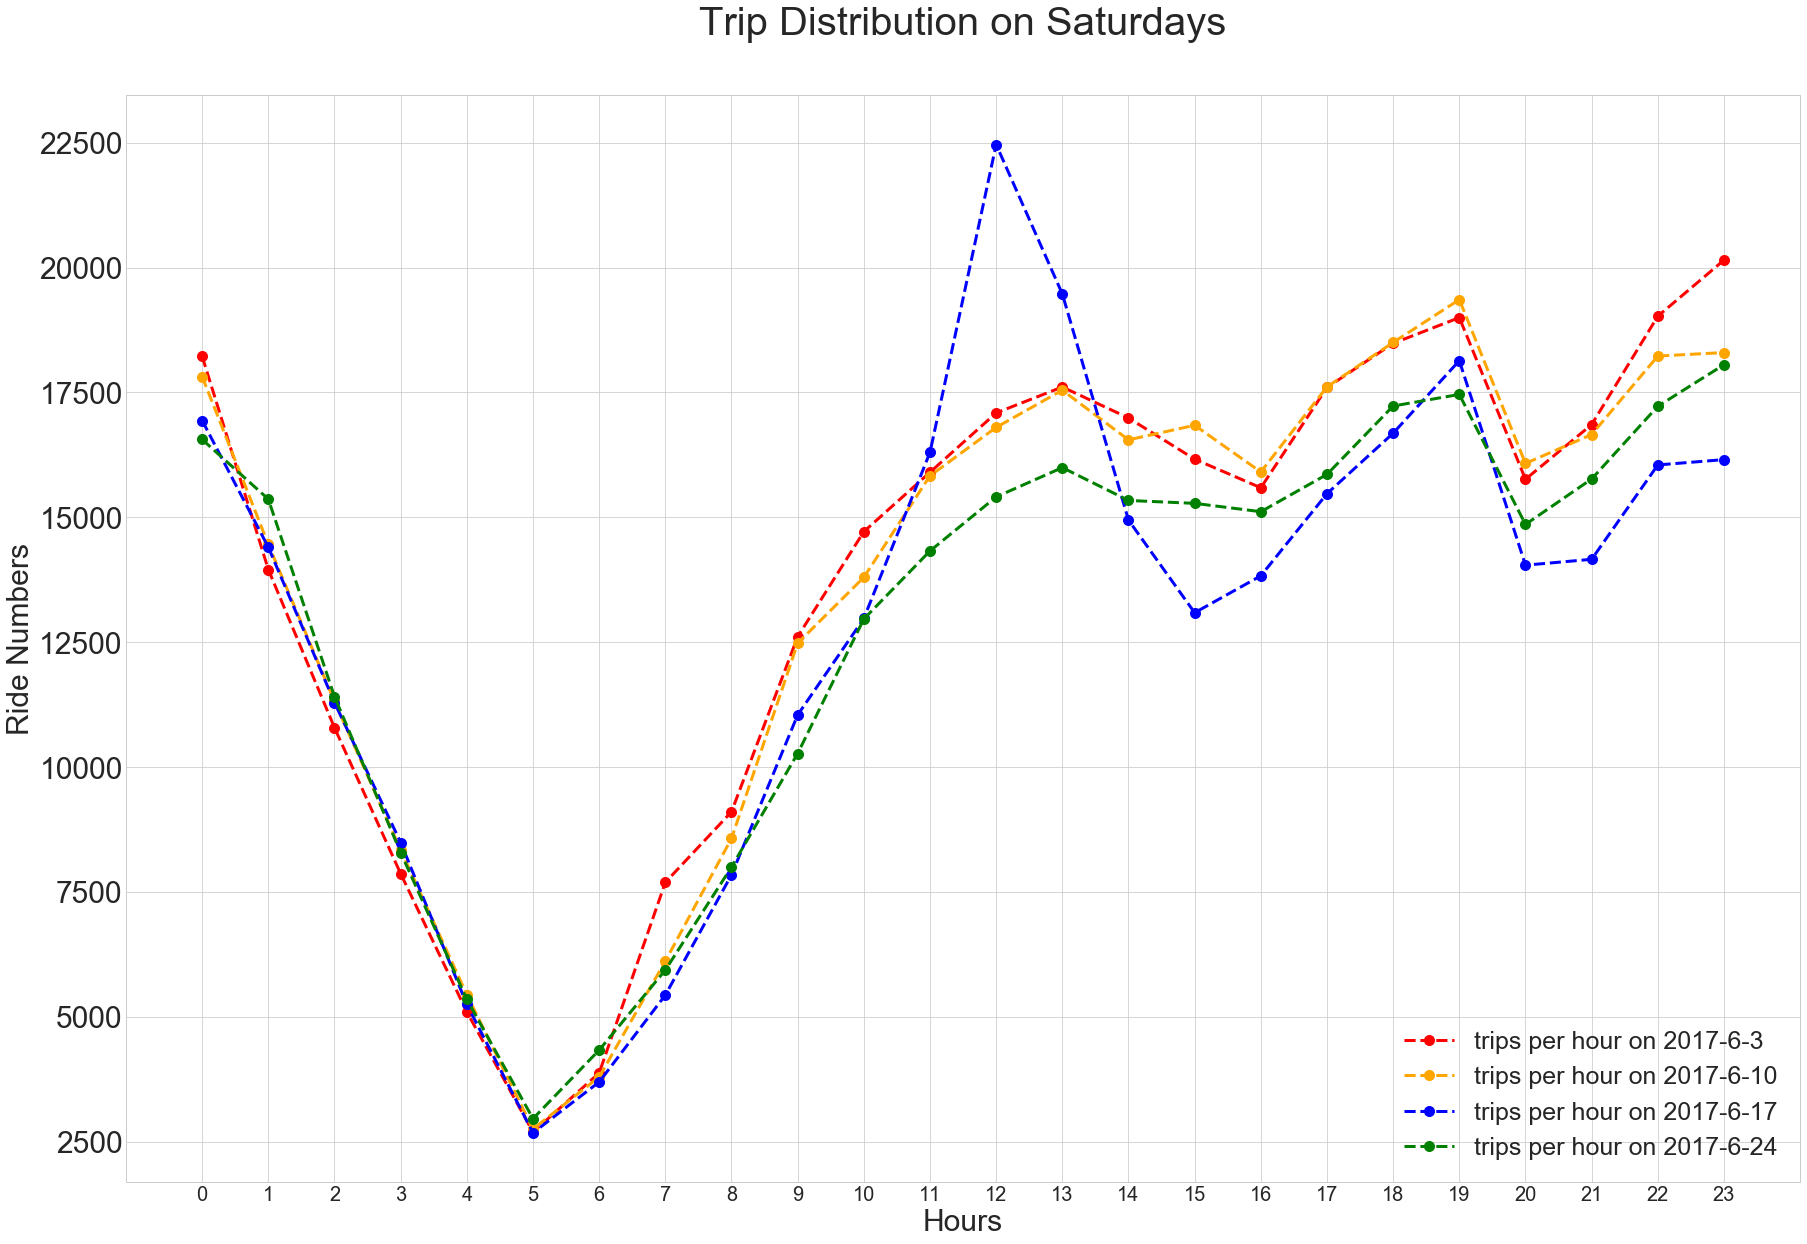

In [141]:
df_sa['date'] = df_sa['pu_dates'].dt.date
df_sa1 = df_sa[df_sa['date'] == datetime.date(2017, 6, 3)]
df_sa2 = df_sa[df_sa['date'] == datetime.date(2017, 6, 10)]
df_sa3 = df_sa[df_sa['date'] == datetime.date(2017, 6, 17)]
df_sa4 = df_sa[df_sa['date'] == datetime.date(2017, 6, 24)]

colors = ['red', 'orange', 'blue', 'green']
dates = ['2017-6-3', '2017-6-10', '2017-6-17', '2017-6-24']
dfs = [df_sa1, df_sa2, df_sa3, df_sa4]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(4):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Saturdays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [142]:
df_sa_hour1819 = pd.DataFrame(df_sa[(df_sa['hour'] == 18) | (df_sa['hour'] == 19)].groupby(['PULocationID']).size())
df_sa_hour2223 = pd.DataFrame(df_sa[(df_sa['hour'] == 22) | (df_sa['hour'] == 23)].groupby(['PULocationID']).size())
df_sa_hour01 = pd.DataFrame(df_sa[(df_sa['hour'] == 0) | (df_sa['hour'] == 1)].groupby(['PULocationID']).size())
df_sa_hour23 = pd.DataFrame(df_sa[(df_sa['hour'] == 2) | (df_sa['hour'] == 3)].groupby(['PULocationID']).size())

df_sa_hour1819.columns = ['Count']
df_sa_hour2223.columns = ['Count']
df_sa_hour01.columns = ['Count']
df_sa_hour23.columns = ['Count']


lst1 = []
lst2 = []
for i in df_sa_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_sa_hour2223.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_sa_hour01.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])
            
lst7 = []
lst8 = []
for i in df_sa_hour23.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
df_sa_hour1819['Borough'] = lst1
df_sa_hour1819['Zone'] = lst2

df_sa_hour2223['Borough'] = lst3
df_sa_hour2223['Zone'] = lst4

df_sa_hour01['Borough'] = lst5
df_sa_hour01['Zone'] = lst6

df_sa_hour23['Borough'] = lst7
df_sa_hour23['Zone'] = lst8

In [343]:
idxsa1819 = df_sa_hour1819.sort_values(by='Count', ascending=False)
#idxsa1819.to_csv('saturdays1819.csv')
idxsa1819.head()

,Count,Borough,Zone
PULocationID,,,
186,5162,Manhattan,Penn Station/Madison Sq West
161,5122,Manhattan,Midtown Center
237,5103,Manhattan,Upper East Side South
142,5021,Manhattan,Lincoln Square East
236,4544,Manhattan,Upper East Side North


In [345]:
dfsa1819 = df_sa[(df_sa['hour'] == 18) | (df_sa['hour'] == 19)]


avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxsa1819.index:
    
    avgf = dfsa1819[dfsa1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfsa1819[dfsa1819['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfsa1819[dfsa1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
saturdays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxsa1819.Zone)

#saturdays1819.to_csv('saturdays_report1819.csv')
saturdays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Penn Station/Madison Sq West,13.828754,2.177307,14.719828,6.35,0.94,0.15
Midtown Center,12.597228,1.927417,13.495174,6.54,0.93,0.14
Upper East Side South,11.752753,1.873310,11.241966,6.27,1.05,0.17
Lincoln Square East,12.341143,2.030127,11.873093,6.08,1.04,0.17
Upper East Side North,12.311673,2.103658,11.389847,5.85,1.08,0.18


In [346]:
print(saturdays1819['Average Fare per mile'].head(55).mean())
print(saturdays1819['Average Fare per minute'].head(55).mean())
print(saturdays1819['Average Distance per minute'].head(55).mean())

5.856181818181817
1.0134545454545454
0.17636363636363636


In [347]:
idxsa2223 = df_sa_hour2223.sort_values(by='Count', ascending=False)
#idxsa2223.to_csv('saturdays2223.csv')
idxsa2223.head()

,Count,Borough,Zone
PULocationID,,,
79,7359,Manhattan,East Village
230,6254,Manhattan,Times Sq/Theatre District
48,6103,Manhattan,Clinton East
249,5392,Manhattan,West Village
142,5387,Manhattan,Lincoln Square East


In [348]:
dfsa2223 = df_sa[(df_sa['hour'] == 22) | (df_sa['hour'] == 23)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxsa2223.index:
    
    avgf = dfsa2223[dfsa2223['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfsa2223[dfsa2223['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfsa2223[dfsa2223['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
saturdays2223 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxsa2223.Zone)

#saturdays2223.to_csv('saturdays_report2223.csv')
saturdays2223.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.524819,2.449999,13.614599,5.93,1.07,0.18
Times Sq/Theatre District,14.069362,2.358203,13.671738,5.97,1.03,0.17
Clinton East,14.781896,2.596736,13.768188,5.69,1.07,0.19
West Village,14.436382,2.410580,13.780681,5.99,1.05,0.17
Lincoln Square East,13.986855,2.513846,12.526533,5.56,1.12,0.20


In [349]:
print(saturdays2223['Average Fare per mile'].head(55).mean())
print(saturdays2223['Average Fare per minute'].head(55).mean())
print(saturdays2223['Average Distance per minute'].head(55).mean())

5.438909090909091
1.1305454545454547
0.21181818181818182


In [350]:
idxsa01 = df_sa_hour01.sort_values(by='Count', ascending=False)
#idxsa01.to_csv('saturdays01.csv')
idxsa01.head()

,Count,Borough,Zone
PULocationID,,,
79,11464,Manhattan,East Village
148,8016,Manhattan,Lower East Side
249,6019,Manhattan,West Village
114,5454,Manhattan,Greenwich Village South
48,5302,Manhattan,Clinton East


In [351]:
dfsa01 = df_sa[(df_sa['hour'] == 0) | (df_sa['hour'] == 1)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxsa01.index:
    
    avgf = dfsa01[dfsa01['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfsa01[dfsa01['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfsa01[dfsa01['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
saturdays01 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxsa01.Zone)

#saturdays01.to_csv('saturdays_report01.csv')
saturdays01.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.615034,2.630449,12.747786,5.56,1.15,0.21
Lower East Side,15.933845,2.989022,13.855273,5.33,1.15,0.22
West Village,15.263653,2.798367,13.748316,5.45,1.11,0.20
Greenwich Village South,14.615149,2.565702,13.221397,5.70,1.11,0.19
Clinton East,15.421403,3.053634,13.028502,5.05,1.18,0.23


In [352]:
print(saturdays01['Average Fare per mile'].head(55).mean())
print(saturdays01['Average Fare per minute'].head(55).mean())
print(saturdays01['Average Distance per minute'].head(55).mean())

5.0680000000000005
1.220909090909091
0.24490909090909088


In [353]:
idxsa23 = df_sa_hour23.sort_values(by='Count', ascending=False)
#idxsa23.to_csv('saturdays23.csv')
idxsa23.head()

,Count,Borough,Zone
PULocationID,,,
79,8958,Manhattan,East Village
148,7727,Manhattan,Lower East Side
249,3722,Manhattan,West Village
114,3699,Manhattan,Greenwich Village South
68,3617,Manhattan,East Chelsea


In [354]:
dfsa23 = df_sa[(df_sa['hour'] == 2) | (df_sa['hour'] == 3)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxsa23.index:
    
    avgf = dfsa23[dfsa23['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfsa23[dfsa23['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfsa23[dfsa23['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
saturdays23 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxsa23.Zone)

#saturdays23.to_csv('saturdays_report23.csv')
saturdays23.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.698898,2.946476,11.328142,4.99,1.30,0.26
Lower East Side,15.613309,3.166756,12.301372,4.93,1.27,0.26
West Village,15.420492,3.147222,12.361365,4.90,1.25,0.25
Greenwich Village South,14.756413,2.924707,11.908327,5.05,1.24,0.25
East Chelsea,14.787799,2.985311,11.830744,4.95,1.25,0.25


In [355]:
print(saturdays23['Average Fare per mile'].head(55).mean())
print(saturdays23['Average Fare per minute'].head(55).mean())
print(saturdays23['Average Distance per minute'].head(55).mean())

4.7005454545454555
1.3461818181818175
0.28963636363636364


In [360]:
df_sa_hourr = pd.DataFrame(df_sa[(df_sa['hour'] == 0) | (df_sa['hour'] == 1) | (df_sa['hour'] == 2) | (df_sa['hour'] == 3)].groupby(['PULocationID']).size())
df_sa_hourr.columns = ['Count']

lstr1 = []
lstr2 = []
for i in df_sa_hourr.index:
    for j in df1.LocationID:
        if i == j:
            lstr1.append(df1['Borough'].iloc[j-1])
            lstr2.append(df1['Zone'].iloc[j-1])
            
df_sa_hourr['Borough'] = lstr1
df_sa_hourr['Zone'] = lstr2

idxsar = df_sa_hourr.sort_values(by='Count', ascending=False)
#idxsar.to_csv('saturdays04.csv')
idxsar.head()

,Count,Borough,Zone
PULocationID,,,
79,20422,Manhattan,East Village
148,15743,Manhattan,Lower East Side
249,9741,Manhattan,West Village
114,9153,Manhattan,Greenwich Village South
48,8561,Manhattan,Clinton East


In [358]:
dfsar = df_sa[(df_sa['hour'] == 0) | (df_sa['hour'] == 1) | (df_sa['hour'] == 2) | (df_sa['hour'] == 3)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxsar.index:
    
    avgf = dfsar[dfsar['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfsar[dfsar['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfsar[dfsar['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
saturdays0123 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxsar.Zone)

#saturdays0123.to_csv('saturdays_report0123.csv')
saturdays0123.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.651821,2.769073,12.125067,5.29,1.21,0.23
Lower East Side,15.776519,3.076257,13.092585,5.13,1.20,0.23
West Village,15.323581,2.931663,13.218367,5.23,1.16,0.22
Greenwich Village South,14.672238,2.710787,12.690746,5.41,1.16,0.21
Clinton East,15.694745,3.235201,12.623510,4.85,1.24,0.26


In [359]:
print(saturdays0123['Average Fare per mile'].head(55).mean())
print(saturdays0123['Average Fare per minute'].head(55).mean())
print(saturdays0123['Average Distance per minute'].head(55).mean())

4.9123636363636365
1.2614545454545454
0.2605454545454545


In [361]:
sum(idxsar['Count'].head(55)) / sum(idxsar['Count'])

0.9461087752082846

In [362]:
# compute proportion of dropp offs in Manhattan compared to total number of drop offs

df_sa_hourr1 = pd.DataFrame(df_sa[(df_sa['hour'] == 0) | (df_sa['hour'] == 1) | (df_sa['hour'] == 2) | (df_sa['hour'] == 3)].groupby(['DOLocationID']).size())
df_sa_hourr1.columns = ['Count']

l1 = []
l2 = []
for i in df_sa_hourr1.index:
    for j in df1.LocationID:
        if i == j:
            l1.append(df1['Borough'].iloc[j-1])
            l2.append(df1['Zone'].iloc[j-1])
            
df_sa_hourr1['DO_Borough'] = l1
df_sa_hourr1['DO_Zone'] = l2

df_sa_hourr1.sort_values(by = 'Count', ascending=False).head()

,Count,DO_Borough,DO_Zone
DOLocationID,,,
79,10619,Manhattan,East Village
48,6752,Manhattan,Clinton East
170,6499,Manhattan,Murray Hill
68,5759,Manhattan,East Chelsea
107,5553,Manhattan,Gramercy


In [363]:
print(sum(df_sa_hourr1[df_sa_hourr1['DO_Borough'] == 'Manhattan'].Count))
print(sum(df_sa_hourr[df_sa_hourr['Borough'] == 'Manhattan'].Count))

print()
print(sum(df_sa_hourr1.Count))
print(sum(df_sa_hourr.Count))

print()
print(164874/205488)
print(188857/205488)

164874
188857

205488
205488

0.8023534220976407
0.9190658335279919


# Sunday

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


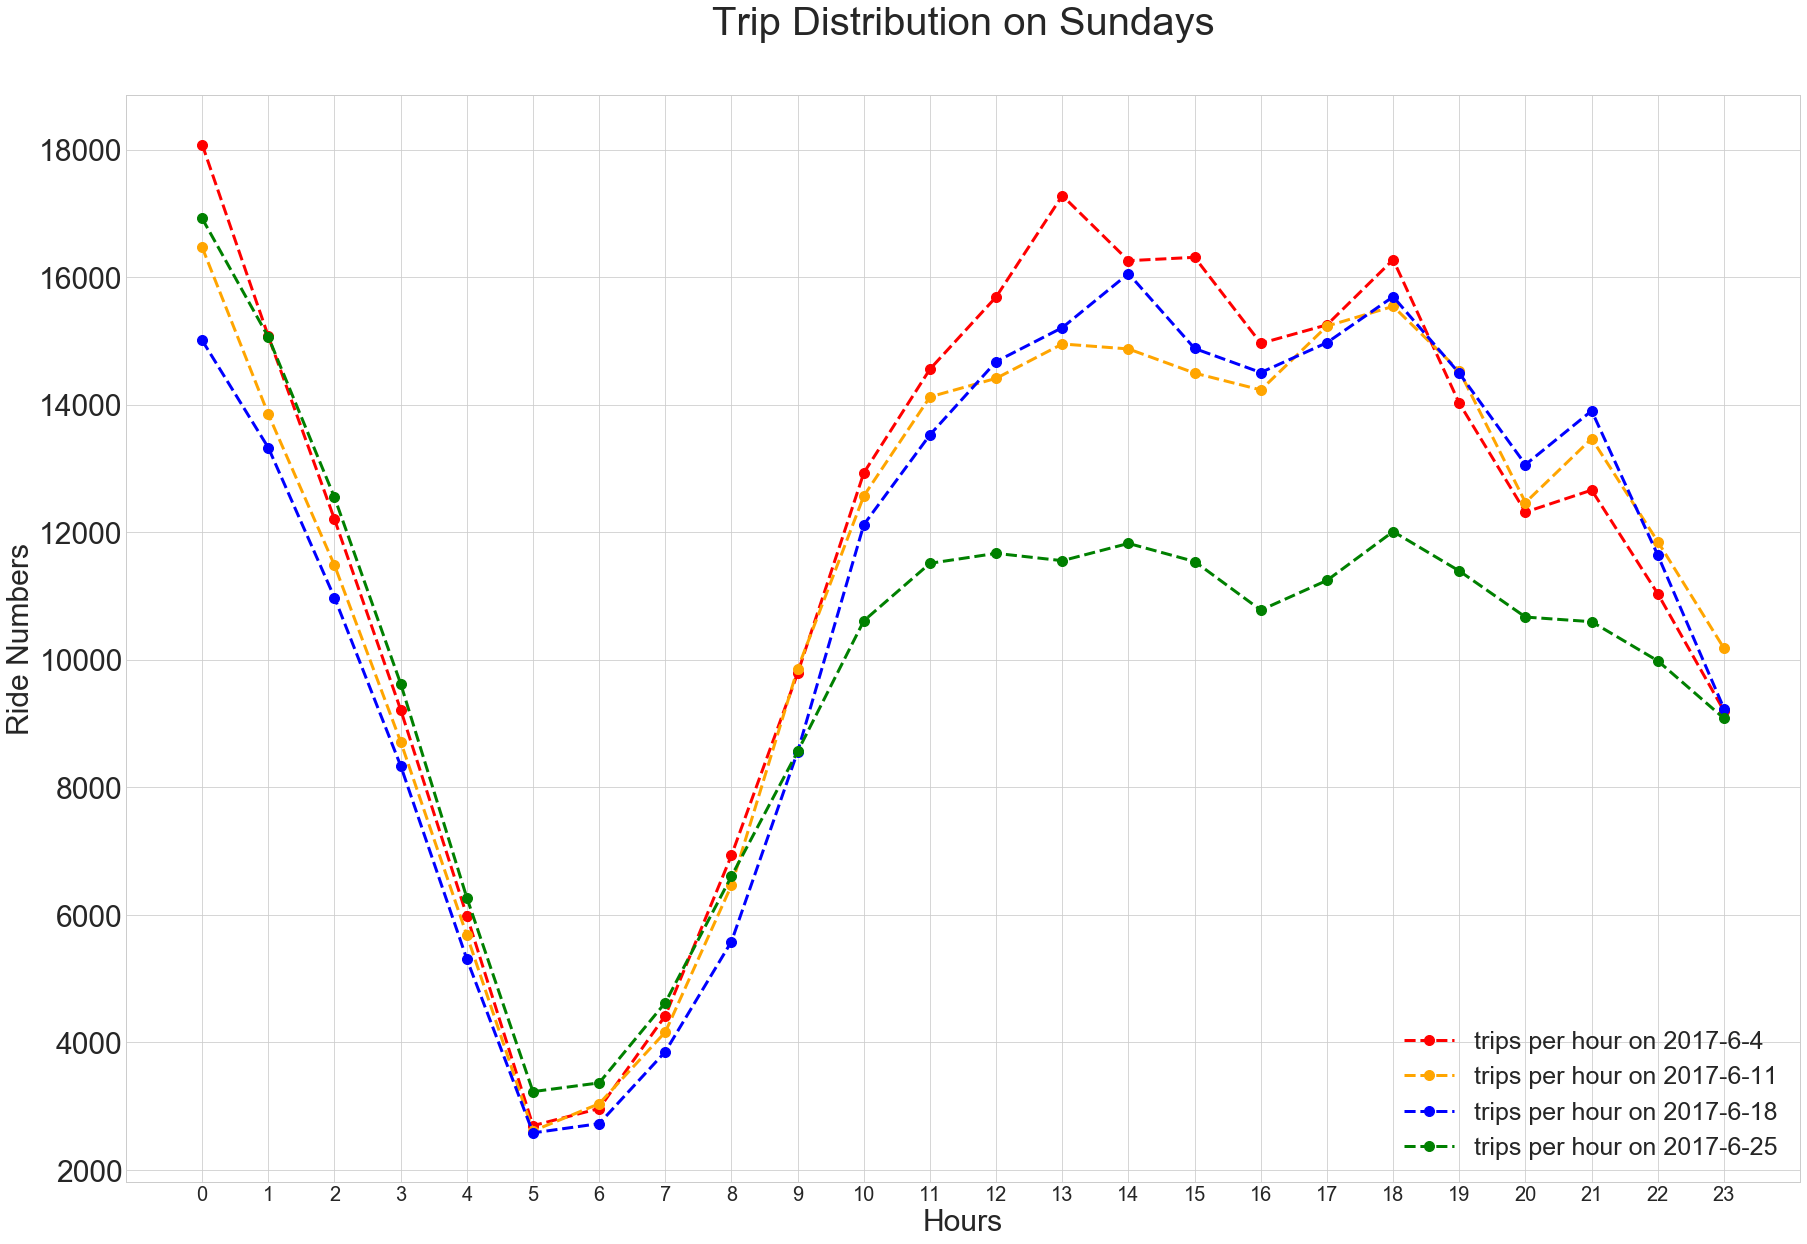

In [169]:
df_s['date'] = df_s['pu_dates'].dt.date
df_s1 = df_s[df_s['date'] == datetime.date(2017, 6, 4)]
df_s2 = df_s[df_s['date'] == datetime.date(2017, 6, 11)]
df_s3 = df_s[df_s['date'] == datetime.date(2017, 6, 18)]
df_s4 = df_s[df_s['date'] == datetime.date(2017, 6, 25)]

colors = ['red', 'orange', 'blue', 'green']
dates = ['2017-6-4', '2017-6-11', '2017-6-18', '2017-6-25']
dfs = [df_s1, df_s2, df_s3, df_s4]

plt.figure(figsize=(30,20))
plt.style.use('seaborn-whitegrid')

for i in range(4):
    
    t2 = dfs[i].groupby(['hour']).size()
    plt.plot(t2, label='trips per hour on ' + dates[i], 
             linewidth = 3, linestyle = '--', marker = 'o', markersize = 10, color = colors[i])


plt.legend(loc='lower right', prop={'size': 25}) 
plt.xlabel("Hours", size = 30)
plt.ylabel("Ride Numbers", size = 30)
plt.title("Trip Distribution on Sundays", size = 40, y=1.05)
plt.xticks(range(0, 24), size = 20)
plt.yticks(size = 30)
plt.show()

In [364]:
df_s_hour01 = pd.DataFrame(df_s[(df_s['hour'] == 0) | (df_s['hour'] == 1)].groupby(['PULocationID']).size())
df_s_hour23 = pd.DataFrame(df_s[(df_s['hour'] == 2) | (df_s['hour'] == 3)].groupby(['PULocationID']).size())
df_s_hour1314 = pd.DataFrame(df_s[(df_s['hour'] == 13) | (df_s['hour'] == 14)].groupby(['PULocationID']).size())
df_s_hour1819 = pd.DataFrame(df_s[(df_s['hour'] == 18) | (df_s['hour'] == 19)].groupby(['PULocationID']).size())


df_s_hour01.columns = ['Count']
df_s_hour23.columns = ['Count']
df_s_hour1314.columns = ['Count']
df_s_hour1819.columns = ['Count']

lst1 = []
lst2 = []
for i in df_s_hour01.index:
    for j in df1.LocationID:
        if i == j:
            lst1.append(df1['Borough'].iloc[j-1])
            lst2.append(df1['Zone'].iloc[j-1])
            
lst3 = []
lst4 = []
for i in df_s_hour23.index:
    for j in df1.LocationID:
        if i == j:
            lst3.append(df1['Borough'].iloc[j-1])
            lst4.append(df1['Zone'].iloc[j-1])
            
lst5 = []
lst6 = []
for i in df_s_hour1314.index:
    for j in df1.LocationID:
        if i == j:
            lst5.append(df1['Borough'].iloc[j-1])
            lst6.append(df1['Zone'].iloc[j-1])
            
lst7 = []
lst8 = []
for i in df_s_hour1819.index:
    for j in df1.LocationID:
        if i == j:
            lst7.append(df1['Borough'].iloc[j-1])
            lst8.append(df1['Zone'].iloc[j-1])
            
df_s_hour01['Borough'] = lst1
df_s_hour01['Zone'] = lst2

df_s_hour23['Borough'] = lst3
df_s_hour23['Zone'] = lst4

df_s_hour1314['Borough'] = lst5
df_s_hour1314['Zone'] = lst6

#df_s_hour2122['Borough'] = lst9
#df_s_hour2122['Zone'] = lst10

df_s_hour1819['Borough'] = lst7
df_s_hour1819['Zone'] = lst8



In [365]:
idxs01 = df_s_hour01.sort_values(by='Count', ascending=False)
#idxs01.to_csv('sundays01.csv')
idxs01.head()

,Count,Borough,Zone
PULocationID,,,
79,10341,Manhattan,East Village
148,7703,Manhattan,Lower East Side
249,5752,Manhattan,West Village
48,5588,Manhattan,Clinton East
114,4629,Manhattan,Greenwich Village South


In [366]:
dfs01 = df_s[(df_s['hour'] == 0) | (df_s['hour'] == 1)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxs01.index:
    
    avgf = dfs01[dfs01['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfs01[dfs01['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfs01[dfs01['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
sundays01 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxs01.Zone)

#sundays01.to_csv('sundays_report01.csv')
sundays01.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.443999,2.627013,12.448848,5.50,1.16,0.21
Lower East Side,15.996508,3.000064,13.979629,5.33,1.14,0.21
West Village,15.028215,2.750144,13.333412,5.46,1.13,0.21
Clinton East,15.170055,2.942309,13.010848,5.16,1.17,0.23
Greenwich Village South,14.817321,2.662322,13.171603,5.57,1.12,0.20


In [367]:
print(sundays01['Average Fare per mile'].head(55).mean())
print(sundays01['Average Fare per minute'].head(55).mean())
print(sundays01['Average Distance per minute'].head(55).mean())

5.065090909090909
1.2114545454545451
0.24345454545454542


In [368]:
idxs23 = df_s_hour23.sort_values(by='Count', ascending=False)
#idxs23.to_csv('sundays23.csv')
idxs23.head()

,Count,Borough,Zone
PULocationID,,,
79,9592,Manhattan,East Village
148,8203,Manhattan,Lower East Side
249,4032,Manhattan,West Village
68,3849,Manhattan,East Chelsea
48,3661,Manhattan,Clinton East


In [369]:
dfs23 = df_s[(df_s['hour'] == 2) | (df_s['hour'] == 3)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxs23.index:
    
    avgf = dfs23[dfs23['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfs23[dfs23['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfs23[dfs23['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
sundays23 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxs23.Zone)

#sundays23.to_csv('sundays_report23.csv')
sundays23.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.631672,2.973168,11.132209,4.92,1.31,0.27
Lower East Side,15.615826,3.213872,11.977498,4.86,1.30,0.27
West Village,15.661121,3.270342,12.466034,4.79,1.26,0.26
East Chelsea,14.786890,2.969992,11.741595,4.98,1.26,0.25
Clinton East,15.923365,3.492663,11.853637,4.56,1.34,0.29


In [370]:
print(sundays23['Average Fare per mile'].head(55).mean())
print(sundays23['Average Fare per minute'].head(55).mean())
print(sundays23['Average Distance per minute'].head(55).mean())

4.662909090909092
1.3621818181818182
0.2952727272727273


In [371]:
idxs1314 = df_s_hour1314.sort_values(by='Count', ascending=False)
#idxs1314.to_csv('sundays1314.csv')
idxs1314.head()

,Count,Borough,Zone
PULocationID,,,
236,4466,Manhattan,Upper East Side North
239,4328,Manhattan,Upper West Side South
237,4305,Manhattan,Upper East Side South
186,4246,Manhattan,Penn Station/Madison Sq West
138,4129,Queens,LaGuardia Airport


In [372]:
dfs1314 = df_s[(df_s['hour'] == 13) | (df_s['hour'] == 14)]


avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxs1314.index:
    
    avgf = dfs1314[dfs1314['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfs1314[dfs1314['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfs1314[dfs1314['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
sundays1314 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxs1314.Zone)

#sundays1314.to_csv('sundays_report1314.csv')
sundays1314.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Upper East Side North,13.043233,2.229801,12.474201,5.85,1.05,0.18
Upper West Side South,13.465501,2.256386,13.214171,5.97,1.02,0.17
Upper East Side South,12.566037,2.069285,12.124359,6.07,1.04,0.17
Penn Station/Madison Sq West,15.597228,2.443641,17.154632,6.38,0.91,0.14
LaGuardia Airport,41.187418,10.013565,41.002567,4.11,1.00,0.24


In [373]:
print(sundays1314['Average Fare per mile'].head(55).mean())
print(sundays1314['Average Fare per minute'].head(55).mean())
print(sundays1314['Average Distance per minute'].head(55).mean())

5.474545454545454
1.0432727272727271
0.19290909090909086


In [374]:
idxs1819 = df_s_hour1819.sort_values(by='Count', ascending=False)
#idxs1819.to_csv('sundays1819.csv')
idxs1819.head()

,Count,Borough,Zone
PULocationID,,,
186,5427,Manhattan,Penn Station/Madison Sq West
138,5026,Queens,LaGuardia Airport
132,4556,Queens,JFK Airport
142,4171,Manhattan,Lincoln Square East
162,4106,Manhattan,Midtown East


In [375]:
dfs1819 = df_s[(df_s['hour'] == 18) | (df_s['hour'] == 19)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxs1819.index:
    
    avgf = dfs1819[dfs1819['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfs1819[dfs1819['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfs1819[dfs1819['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
sundays1819 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxs1819.Zone)

#sundays1819.to_csv('sundays_report1819.csv')
sundays1819.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
Penn Station/Madison Sq West,15.158038,2.410523,16.135151,6.29,0.94,0.15
LaGuardia Airport,40.291315,9.991827,35.936331,4.03,1.12,0.28
JFK Airport,55.274932,16.775529,52.633428,3.29,1.05,0.32
Lincoln Square East,11.891719,2.056775,10.635551,5.78,1.12,0.19
Midtown East,13.129104,2.242633,12.297780,5.85,1.07,0.18


In [376]:
print(sundays1314['Average Fare per mile'].head(55).mean())
print(sundays1314['Average Fare per minute'].head(55).mean())
print(sundays1314['Average Distance per minute'].head(55).mean())

5.474545454545454
1.0432727272727271
0.19290909090909086


In [377]:
df_s_hourr = pd.DataFrame(df_s[(df_s['hour'] == 0) | (df_s['hour'] == 1) | (df_s['hour'] == 2) | (df_s['hour'] == 3)].groupby(['PULocationID']).size())
df_s_hourr.columns = ['Count']

lstr1 = []
lstr2 = []
for i in df_s_hourr.index:
    for j in df1.LocationID:
        if i == j:
            lstr1.append(df1['Borough'].iloc[j-1])
            lstr2.append(df1['Zone'].iloc[j-1])
            
df_s_hourr['Borough'] = lstr1
df_s_hourr['Zone'] = lstr2

idxsr = df_s_hourr.sort_values(by='Count', ascending=False)
#idxsr.to_csv('sundays0123loc.csv')
idxsr.head()

,Count,Borough,Zone
PULocationID,,,
79,19933,Manhattan,East Village
148,15906,Manhattan,Lower East Side
249,9784,Manhattan,West Village
48,9249,Manhattan,Clinton East
114,8205,Manhattan,Greenwich Village South


In [378]:
dfs0123 = df_s[(df_s['hour'] == 0) | (df_s['hour'] == 1) | (df_s['hour'] == 2) | (df_s['hour'] == 3)]

avgfs = []
avgds = []
avgts = []

l1 = []
l2 = []
l3 = []

for i in idxsr.index:
    
    avgf = dfs0123[dfs0123['PULocationID'] == i]['total_amount'].mean()
    avgfs.append(avgf)
    
    avgd = dfs0123[dfs0123['PULocationID'] == i]['trip_distance'].mean()   
    avgds.append(avgd)
    
    avgt = dfs0123[dfs0123['PULocationID'] == i]['time_difference'].mean()
    avgts.append(avgt)

            
    l1.append(round(avgf/avgd, 2))       
    l2.append(round(avgf/avgt, 2))    
    l3.append(round(avgd/avgt, 2))
    
    
sundays0123 = pd.DataFrame({'Average Total Fare' : avgfs,
                        'Average Trip Distance' : avgds,
                        'Average Trip Time' : avgts,
                        'Average Fare per mile' : l1,
                        'Average Fare per minute' :l2, 
                        'Average Distance per minute' :l3}, index = idxsr.Zone)

#sundays0123.to_csv('sundays_report0123.csv')
sundays0123.head()

,Average Total Fare,Average Trip Distance,Average Trip Time,Average Fare per mile,Average Fare per minute,Average Distance per minute
Zone,,,,,,
East Village,14.534309,2.793587,11.815265,5.20,1.23,0.24
Lower East Side,15.800184,3.110328,12.947095,5.08,1.22,0.24
West Village,15.289036,2.964519,12.975964,5.16,1.18,0.23
Clinton East,15.468235,3.160154,12.552793,4.89,1.23,0.25
Greenwich Village South,14.864661,2.816461,12.567114,5.28,1.18,0.22


In [379]:
print(sundays0123['Average Fare per mile'].head(55).mean())
print(sundays0123['Average Fare per minute'].head(55).mean())
print(sundays0123['Average Distance per minute'].head(55).mean())

4.919090909090909
1.2621818181818185
0.2596363636363636


In [381]:
df_s_hourr1 = pd.DataFrame(df_s[(df_s['hour'] == 0) | (df_s['hour'] == 1) | (df_s['hour'] == 2) | (df_s['hour'] == 3)].groupby(['DOLocationID']).size())
df_s_hourr1.columns = ['Count']

l1 = []
l2 = []
for i in df_s_hourr1.index:
    for j in df1.LocationID:
        if i == j:
            l1.append(df1['Borough'].iloc[j-1])
            l2.append(df1['Zone'].iloc[j-1])
            
df_s_hourr1['DO_Borough'] = l1
df_s_hourr1['DO_Zone'] = l2

dosundays0123 = df_s_hourr1.sort_values(by = 'Count', ascending=False)

print(sum(df_s_hourr1[df_s_hourr1['DO_Borough'] == 'Manhattan'].Count))
print(sum(df_s_hourr[df_s_hourr['Borough'] == 'Manhattan'].Count))

print(sum(df_s_hourr1.Count))
print(sum(df_s_hourr.Count))

print(167432 / sum(df_s_hourr.Count))
print(190763 / sum(df_s_hourr.Count))

167432
190763
206908
206908
0.8092098903860653
0.9219701509849788


In [382]:
# Average number of taxi trips per day

days_cts = df.day_of_week.value_counts()

days_cts[0] = days_cts[0]/5
days_cts[1] = days_cts[1]/5
days_cts[2] = days_cts[2]/4
days_cts[3] = days_cts[3]/4
days_cts[4] = days_cts[4]/4
days_cts[5] = days_cts[5]/4
days_cts[6] = days_cts[6]/4

days_cts

Thursday     331268
Friday       326772
Wednesday    325877
Tuesday      320961
Saturday     320508
Monday       295639
Sunday       268245
Name: day_of_week, dtype: int64